In [1]:
import gc
import json
import os
import pathlib
import shutil

import collections
import cytopus
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import Spectra as spectra

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/spectra_venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
def get_color_annotations(df, mapping):
    result = []
    for column, palette in mapping.items():
        values = df[column].unique()
        if pd.api.types.is_categorical_dtype(df[column]):
            values = df[column].cat.categories
        lut = dict(zip(values, sns.color_palette(palette, n_colors=values.size).as_hex()))
        result.append(df[column].map(lut))
    return pd.concat(result, axis=1)

# Run spectra on BAL object

The goal of this notebook is to run Spectra _properly_.

We use published Spectra version which I reinstalled freshly after Spectra got published in Nature Biotech.

For the input gene sets, we use their default input gene set from the published package.

### 1. Load data

In [4]:
DATA = pathlib.Path('../../data/31_bal-object/')

In [5]:
ds = sc.read_h5ad(DATA / "03_bal-object/03_bal-object.h5ad")

In [6]:
raw_object = sc.read_h5ad(DATA / "raw_object.h5ad")

In [ ]:
raw_object.obs_names = (
    raw_object.obs["External Sample ID"].astype(str)
    + "_"
    + raw_object.obs_names.str.replace("(-\d+)+$", "", regex=True)
)

In [8]:
raw_object = raw_object[ds.obs_names, :].copy()

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/spectra_venv/lib/python3.9/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [9]:
raw_object.obs = ds.obs.copy()
raw_object.obsm["X_umap"] = ds.obsm["X_umap"].copy()
raw_object.uns["cell_type_colors"] = ds.uns["cell_type_colors"].copy()

In [10]:
adata = raw_object

In [11]:
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    layer="counts",
    n_top_genes=3000,
    subset=False,
    batch_key="Patient"
)

Remove uninformative genes from this object. Using new logic from https://github.com/NUPulmonary/SSc-v2/issues/107

In [12]:
REF_GENOME_GTF = '/projects/b1038/tools/refdata-cellranger-GRCh38-1.2.0/genes/genes.gtf'

In [13]:
ref_genome = open(REF_GENOME_GTF).read().split('\n')

In [ ]:
gene_info = []
for line in ref_genome:
    if not line or line[0] == '#':
        continue
    info = line.split('\t')
    line_type = info[2]
    if line_type != 'gene':
        continue
    data = {
        pair.strip().split()[0]: pair.strip().split()[1].strip('"')
        for pair in info[8].split(';')
        if pair.strip()
    }
    gene_info.append(data)
gene_info = pd.DataFrame(gene_info)

There are few duplicate gene names with conflicting biotypes, but we don't care about this: let's just take all gene names that have `protein_coding` biotype.

In [15]:
PROTEIN_CODING = gene_info.gene_name[gene_info.gene_biotype.eq('protein_coding')].unique()

In [16]:
# Either starts with all this, or ends with -AS1
FUNKY_TRANSCRIPTS = (
    '(^(RP\d{1,2}-|LINC|CT[ABCD]-|AC\d{6}|AL\d{6}'
    '|AP\d{6}|AF\d{6}|XXba|XXya|FO\d{6}|FP\d{6}).+|.+(-AS1)$)'
)

In [17]:
adata.var.loc[adata.var_names.str.match(FUNKY_TRANSCRIPTS), "highly_variable"] = False
adata.var.loc[~adata.var_names.isin(PROTEIN_CODING), "highly_variable"] = False

In [18]:
adata.var.highly_variable.sum()

2339

**NB!** Just log1p processing, without cell normalization, per https://github.com/dpeerlab/spectra/blob/main/notebooks/Spectra_Colaboratory_tutorial.ipynb section `Load adata`


In [19]:
sc.pp.log1p(adata)

### 2. Load gene sets from Spectra paper and convert them to expected format

This xsl file is from preprint. Not careful examination with the published supplemental table did not show any difference. Maybe it is there.

In [20]:
gene_sets = pd.read_excel("spectra-gene-sets.xlsx")

In [21]:
# cytopus convention is to use hyphens, let's use hyphens
gene_sets.cell_type = gene_sets.cell_type.replace({
    "B_memory": "B-memory",
    "CD4_T": "CD4-T",
    "CD8_T": "CD8-T",
    "pDC": "p-DC",
})

In [22]:
input_gene_sets = collections.defaultdict(dict)
for _, r in gene_sets.iterrows():
    # TODO: rewrite eval
    input_gene_sets[r.cell_type][r.gene_set_name] = eval(r.gene_set)

In [23]:
', '.join(input_gene_sets['Mac']['M_macrophage_UP'])

'MARCO, CD36, MSR1, CD68, APOE, MRC1, CD163'

Text(0.5, 0, 'Number of programs')

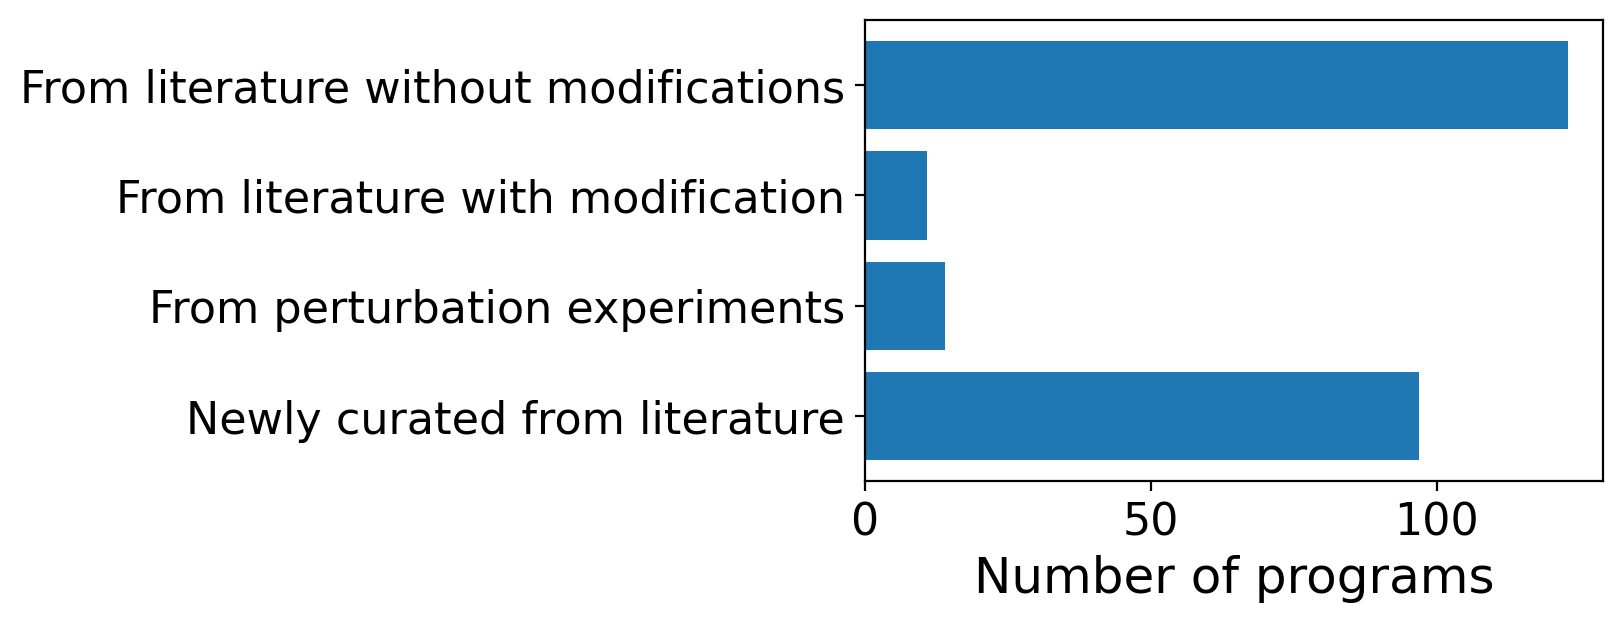

In [ ]:
fig, ax = plt.subplots(figsize=(8, 3), constrained_layout=True)
ax.barh(
    [0, 1, 2, 3],
    [97, 14, 11, 123],
)
ax.set_yticks([0, 1, 2, 3])
ax.set_yticklabels([
    'Newly curated from literature',
    'From perturbation experiments',
    'From literature with modification',
    'From literature without modifications'
], size=16)
ax.tick_params(axis="x", labelsize=16)
ax.set_xlabel("Number of programs", size=18)

Add `leuko` gene sets to `all-cells` as in default spectra gene sets

In [25]:
input_gene_sets['all-cells'].update(input_gene_sets['leukocyte'])

### 3. Define cell types for Spectra

Establish correspondence between our and their cell type names. Cytopus does not have epithelial cells

In [26]:
sorted(adata.obs.cell_type.unique().tolist())

['Activated monocytes',
 'B cells',
 'CCR7+ DC',
 'CD4 TEM cells',
 'CD4 naive T cells',
 'CD8 TEM cells',
 'CD8 TRM cells',
 'Ciliated cells',
 'DC1',
 'DC2',
 'Mast cells',
 'MoAM-1',
 'MoAM-3 mature',
 'MoAM-4 profibrotic',
 'Monocytes',
 'Perivascular macrophages',
 'Proliferating T cells',
 'Proliferating macrophages',
 'Secretory cells',
 'TRAM-1',
 'TRAM-2',
 'TRAM-3',
 'TRAM-4',
 'TRAM-5 MT1G',
 'TRAM-6 activated',
 'Tregs',
 'gd/NKT cells',
 'pDC']

In [ ]:
cell_type_map = {
    # Honestly, this is probably not ok. Hope for *wonderful* new gene set discovery
    "TRAM-1": "Mac",
    "TRAM-2": "Mac",
    "TRAM-3": "Mac",
    "TRAM-4": "Mac",
    "TRAM-5 MT1G": "Mac",
    "TRAM-6 activated": "Mac",
    "Proliferating macrophages": "Mac",

    "MoAM-1": "MDC",
    "MoAM-3 mature": "MDC",
    "MoAM-4 profibrotic": "MDC",
    "Perivascular macrophages": "MDC",

    "Monocytes": "mono",
    "Activated monocytes": "mono",

    "CD4 naive T cells": "CD4-T",
    "CD4 TEM cells": "CD4-T",
    "CD8 TEM cells": "CD8-T",
    "CD8 TRM cells": "CD8-T",

    "Tregs": "Treg",
    "gd/NKT cells": "NK",
    "Proliferating T cells": "T",

    "DC2": "cDC2",
    "DC1": "cDC1",
    "CCR7+ DC": "cDC3",  # Ha, novel annotation!
    "pDC": "p-DC",

    "Mast cells": "mast",
    "B cells": "B",     # Or B-memory??
}

In [28]:
adata.obs["cell_type_spectra"] = adata.obs.cell_type.replace(cell_type_map)

Verify

In [29]:
adata.obs.cell_type_spectra[~adata.obs.cell_type_spectra.isin(input_gene_sets.keys())].unique()

['Ciliated cells', 'Secretory cells']
Categories (16, object): ['B', 'cDC3', 'CD4-T', 'CD8-T', ..., 'Mac', 'Treg', 'NK', 'p-DC']

Let's remove input gene sets that are not for our cell types

In [30]:
present_cell_types = adata.obs.cell_type_spectra.unique().tolist() + ["all-cells"]
input_gene_sets = {k: v for k, v in input_gene_sets.items() if k in present_cell_types}

We need to add empty dictionaries for our extra cell types

In [31]:
present_sets = set(input_gene_sets.keys())
for ct in set(present_cell_types) - present_sets:
    input_gene_sets[ct] = {}

In [32]:
input_gene_sets["global"] = input_gene_sets.pop("all-cells")

In [33]:
cnt = [0, 0]
to_delete = []
for ct, sets in input_gene_sets.items():
    for name, gene_set in sets.items():
        gene_set = list(set(gene_set).intersection(adata.var_names))
        if len(gene_set) < 3:
            cnt[0] += 1
            to_delete.append((ct, name))
        else:
            cnt[1] += 1
            sets[name] = gene_set
for ct, name in to_delete:
    del input_gene_sets[ct][name]
print(f"{cnt[0]} gene sets excluded due to < 3 genes, {cnt[1]} gene sets kept")

0 gene sets excluded due to < 3 genes, 187 gene sets kept


**NB**

1. For the genes, we will take the union of all genes in the gene sets & 3000 HVGs except for uninformative genes
2. If we're not sure about cluster borders, Spectra recommends to use coarser clusters. I will merge TRAM, MoAM, Monocytes & DC2 into one cluster and give it all of the containing gene sets. Same for T cells.
3. It turns out that Spectra sets a predefined number of factors for each cell type & global, depending on the number of gene sets. I will make it estimate 5 additional factors per cell type & globally.

1. Merging cell types

In [34]:
to_merge = ["Mac", "MDC", "mono", "cDC2"]
merge_into = to_merge[0]
for ct in to_merge[1:]:
    input_gene_sets[merge_into].update(input_gene_sets[ct])
    del input_gene_sets[ct]
adata.obs.loc[adata.obs.cell_type_spectra.isin(to_merge[1:]), "cell_type_spectra"] = merge_into

In [35]:
to_merge = ["T", "NK", "Treg", "CD4-T", "CD8-T"]
merge_into = to_merge[0]
for ct in to_merge[1:]:
    input_gene_sets[merge_into].update(input_gene_sets[ct])
    del input_gene_sets[ct]
adata.obs.loc[adata.obs.cell_type_spectra.isin(to_merge[1:]), "cell_type_spectra"] = merge_into

In [36]:
adata.obs.cell_type_spectra = adata.obs.cell_type_spectra.cat.remove_unused_categories()

In [ ]:
spectra.Spectra_util.check_gene_set_dictionary(
    adata,
    input_gene_sets,
    obs_key="cell_type_spectra",
    return_dict=False
)

Cell type labels in gene set annotation dictionary and AnnData object are identical
Your gene set annotation dictionary is now correctly formatted.


2. Add empty factors

In [38]:
L = {ct: len(sets) + 3 for ct, sets in input_gene_sets.items()}

### 4. Define input data to Spectra

Based on https://github.com/dpeerlab/SpectraReproducibility/blob/main/utils/benchmark-utils/simulation_functions.py#L241

and https://github.com/dpeerlab/spectra/blob/main/notebooks/Spectra_Colaboratory_tutorial.ipynb
section `Fitting the model without AnnData`

In [ ]:
input_genes = list(set([
    gene
    for gene_sets in input_gene_sets.values()
    for gene_set in gene_sets.values()
    for gene in gene_set
]))

In [40]:
input_genes = adata.var_names[adata.var_names.isin(input_genes) | adata.var.highly_variable]

In [41]:
adata = adata[:, input_genes].copy()

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/spectra_venv/lib/python3.9/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [42]:
adata.shape

(197208, 5908)

In [43]:
adata.shape

(197208, 5908)

In [44]:
del ds

In [45]:
gc.collect()

1859

In [46]:
expr = np.array(adata.X.todense())

In [47]:
labels = np.array(adata.obs.cell_type_spectra)

### 5. Initialize Spectra model

In [48]:
model = spectra.Spectra.SPECTRA_Model(
    X=expr,
    L=L,
    labels=labels,
    gs_dict=input_gene_sets,
    vocab=list(adata.var_names),
    lam=0.1,  # paper says this allows factor to deviate significantly from input gene sets
    delta=0.001,
    kappa=0.002,
    rho=0.002
)

In [49]:
word2id = dict(zip(adata.var_names, range(len(input_genes))))

In [50]:
%%time
model.initialize(input_gene_sets, word2id, expr, init_scores=None)

CPU times: user 18h 9min 35s, sys: 34.1 s, total: 18h 10min 10s
Wall time: 35min 27s


In [ ]:
%%time
model.train(X=expr, labels=labels, num_epochs=10000, verbose=True)

  1%|          | 97/10000 [04:41<8:21:52,  3.04s/it]

UPDATING LR TO 0.5


  1%|          | 101/10000 [04:53<8:21:27,  3.04s/it]

UPDATING LR TO 0.1


  1%|          | 108/10000 [05:13<7:46:43,  2.83s/it]

UPDATING LR TO 0.01


  1%|▏         | 130/10000 [06:16<7:44:10,  2.82s/it]

UPDATING LR TO 0.001


 83%|████████▎ | 8285/10000 [6:50:50<1:23:37,  2.93s/it]

In [ ]:
model.save("14a_spectra.model")

In [ ]:
# model.load('14a_spectra.model', labels=labels)

In [ ]:
sum(p.numel() for p in model.internal_model.parameters())

In [ ]:
sum(list(L.values()))

In [ ]:
adata.obs.cell_type_spectra.nunique()

In [ ]:
num_params = collections.defaultdict(int)
for k, v in model.internal_model.named_parameters():
    num_params[k.split('.')[0]] += v.numel()
num_params

In [ ]:
adata.uns["SPECTRA_factors"] = model.factors

In [ ]:
adata.uns["SPECTRA_markers"] = spectra.Spectra.return_markers(
    factor_matrix=model.factors,
    id2word={v: k for k, v in word2id.items()},
    n_top_vals=50
)

In [ ]:
adata.uns["SPECTRA_L"] = L

In [ ]:
adata.obsm["SPECTRA_cell_scores"] = model.cell_scores

In [ ]:
factor_celltypes = spectra.get_factor_celltypes(adata, 'cell_type_spectra', model.cell_scores)

In [ ]:
gene_weights = pd.DataFrame(
    adata.uns['SPECTRA_factors'],
    index=[f"{factor_celltypes[x]}_{x}" for x in range(adata.uns['SPECTRA_factors'].shape[0])],
    columns=adata.var_names
).T

In [ ]:
gene_weights.round(5).to_csv("14a_gene-weights.csv")

In [ ]:
cell_scores = pd.DataFrame(
    adata.obsm['SPECTRA_cell_scores'],
    index=adata.obs_names,
    columns=[f"{factor_celltypes[x]}_{x}" for x in range(adata.uns['SPECTRA_factors'].shape[0])]
)

In [ ]:
cell_scores = cell_scores.round(5)

In [ ]:
adata.obs = pd.concat([adata.obs, cell_scores], axis=1)

Rename factors to pretty names

In [ ]:
orig_factor_names = model.matching(adata.uns["SPECTRA_markers"], input_gene_sets)

In [ ]:
orig_factor_names_map = {}
for i, orig_name in enumerate(orig_factor_names):
    curr_name = cell_scores.columns[i]
    ct = factor_celltypes[i]
    if orig_name == "0":
        new_name = f"F_{i}_{ct}"
    elif ct != "global":
        new_name = f"F_{i}_{ct}_{orig_name.replace(ct, '')}"
    else:
        new_name = f"F_{i}_{orig_name}"
    orig_factor_names_map[curr_name] = new_name

In [ ]:
adata.obs.rename(columns=orig_factor_names_map, inplace=True)

In [ ]:
os.makedirs("../../data/31_bal-object/14a_spectra", exist_ok=True)

In [ ]:
adata.write_h5ad("../../data/31_bal-object/14a_spectra/14a_spectra.h5ad")

In [ ]:
adata.obs.to_csv("../../data/31_bal-object/14a_spectra/14a_spectra-metadata.csv")

In [ ]:
shutil.copy(
    "../../data/31_bal-object/03_bal-object/03_bal-object-markers.csv",
    "../../data/31_bal-object/14a_spectra/14a_spectra-markers.csv"
)

In [121]:
factor_interactions = model.return_eta()

<Axes: >

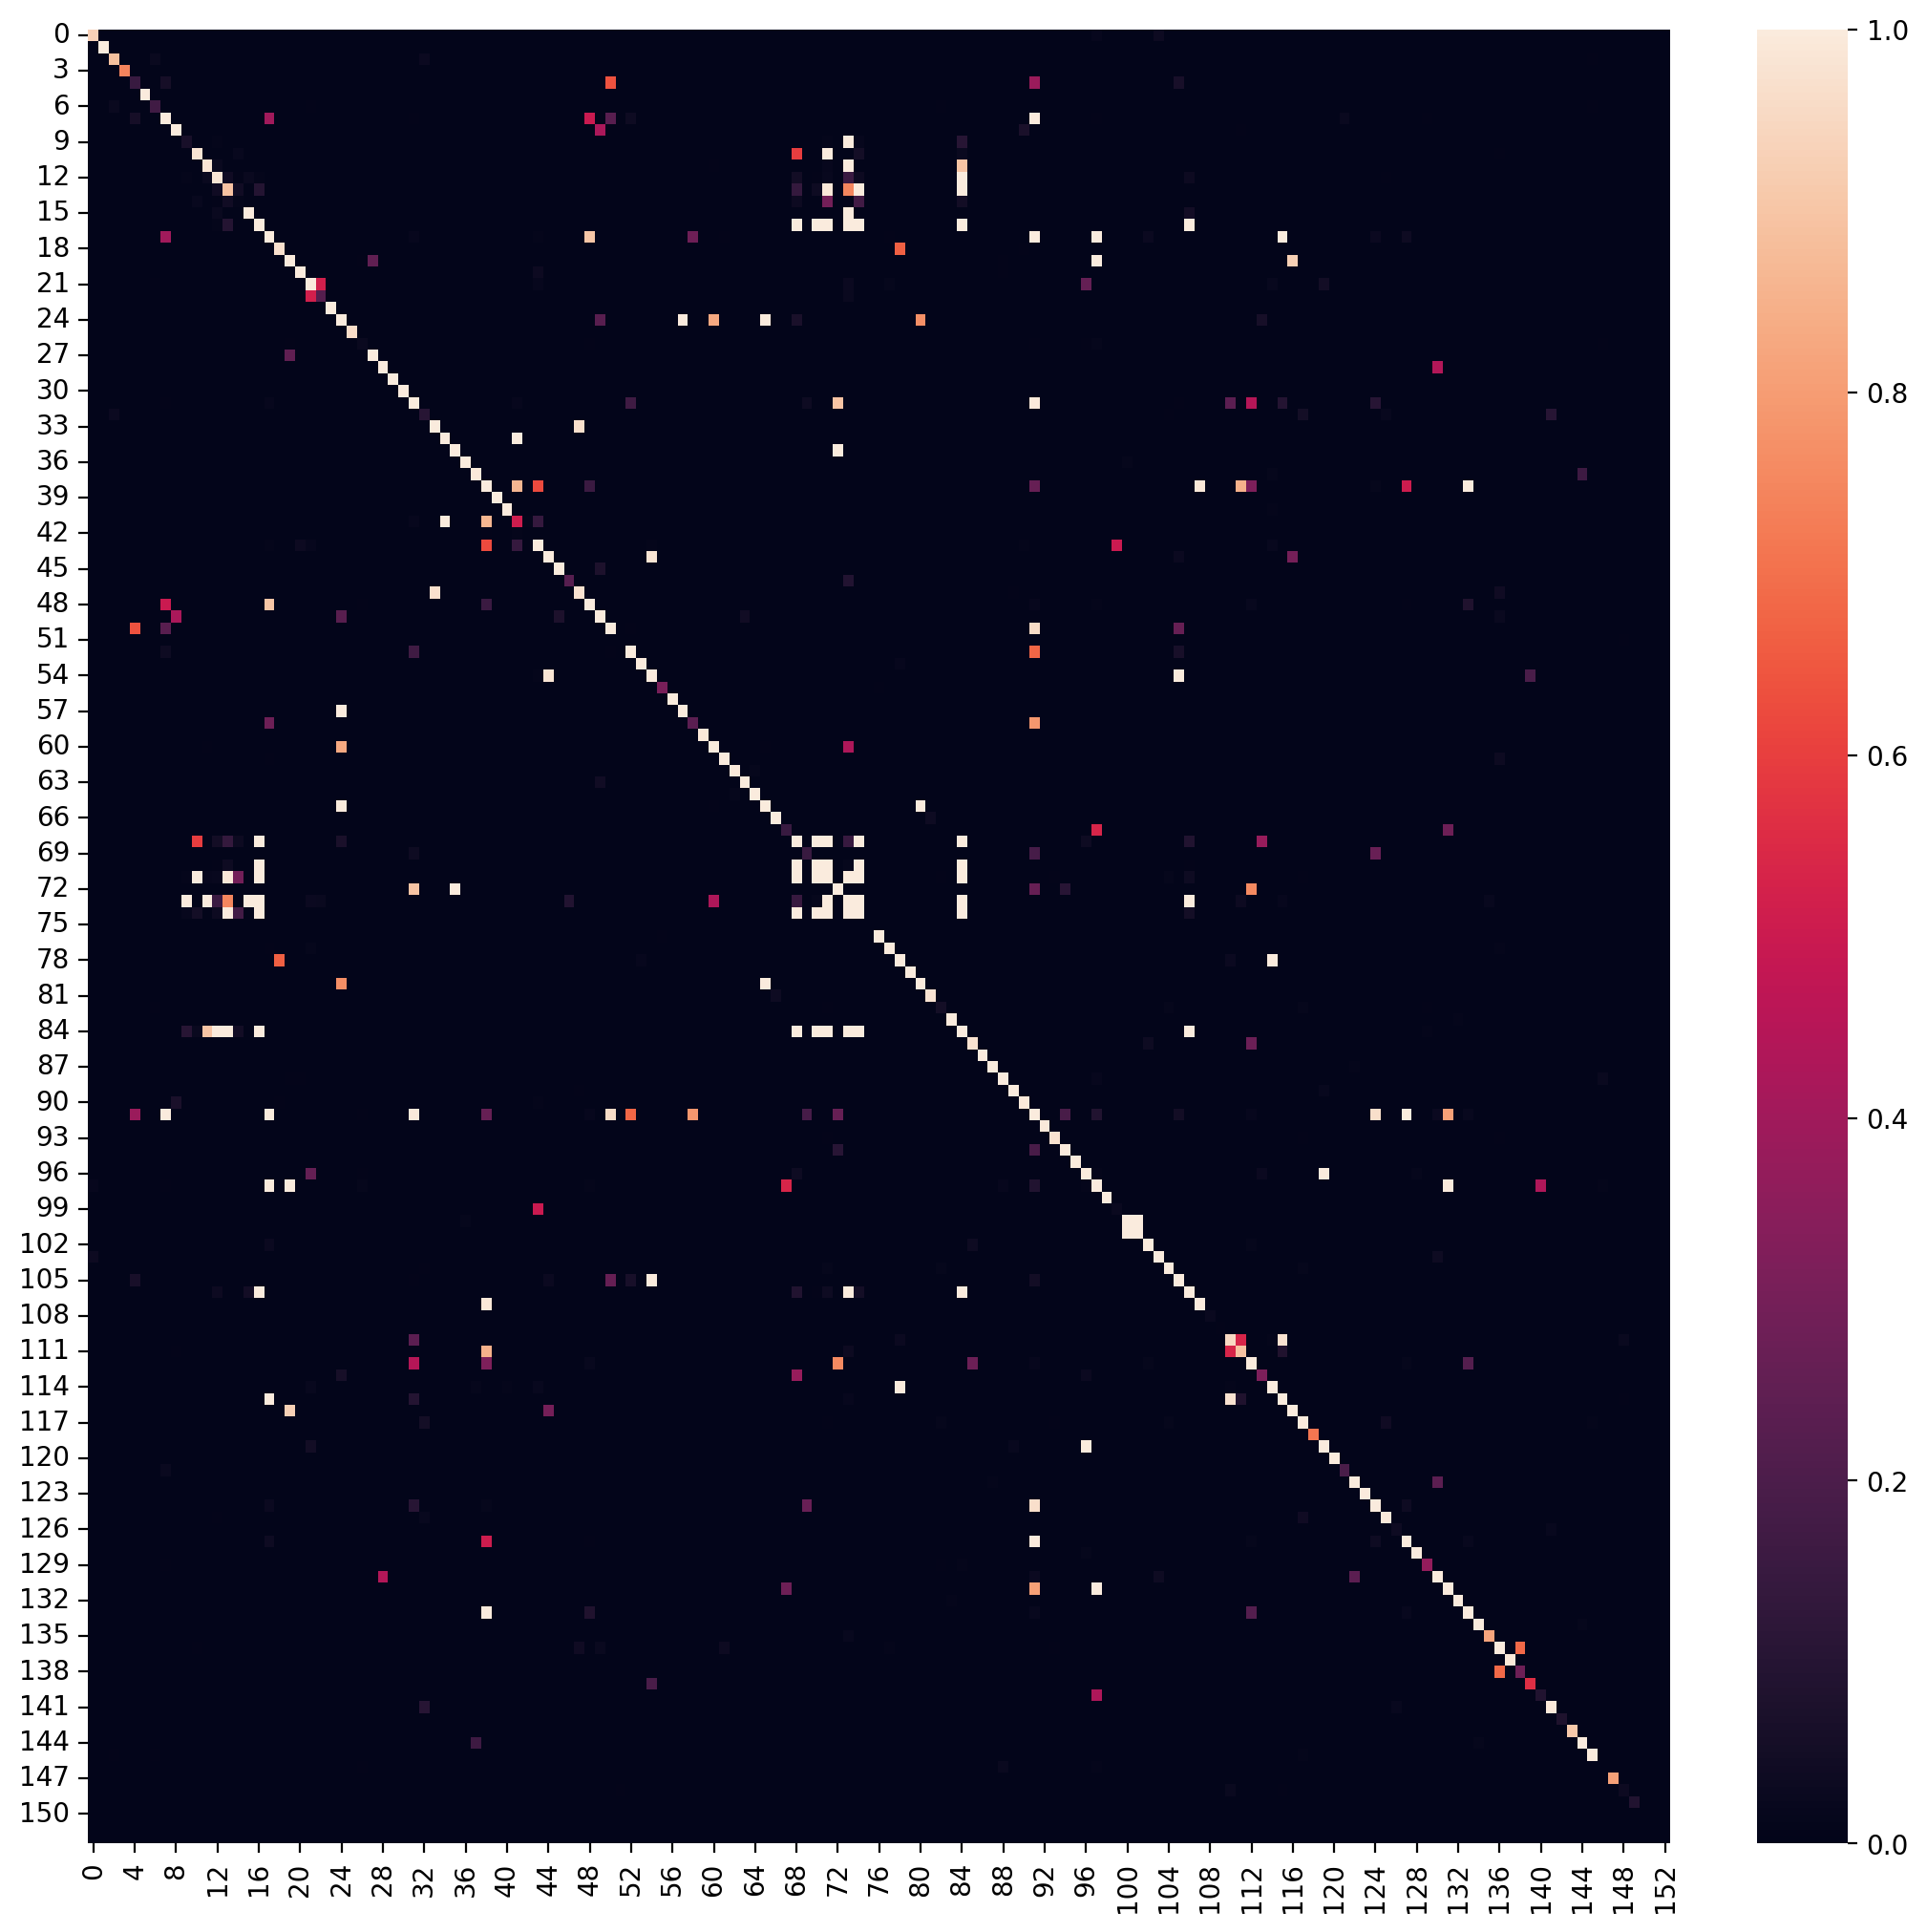

In [122]:
fig, ax = plt.subplots(figsize=(10, 10), constrained_layout=True)
sns.heatmap(
    factor_interactions['global'],
    ax=ax
)

In [123]:
gene_scalings = model.return_gene_scalings()

In [124]:
gene_names = adata.var_names

In [125]:
gene_names.size

5908

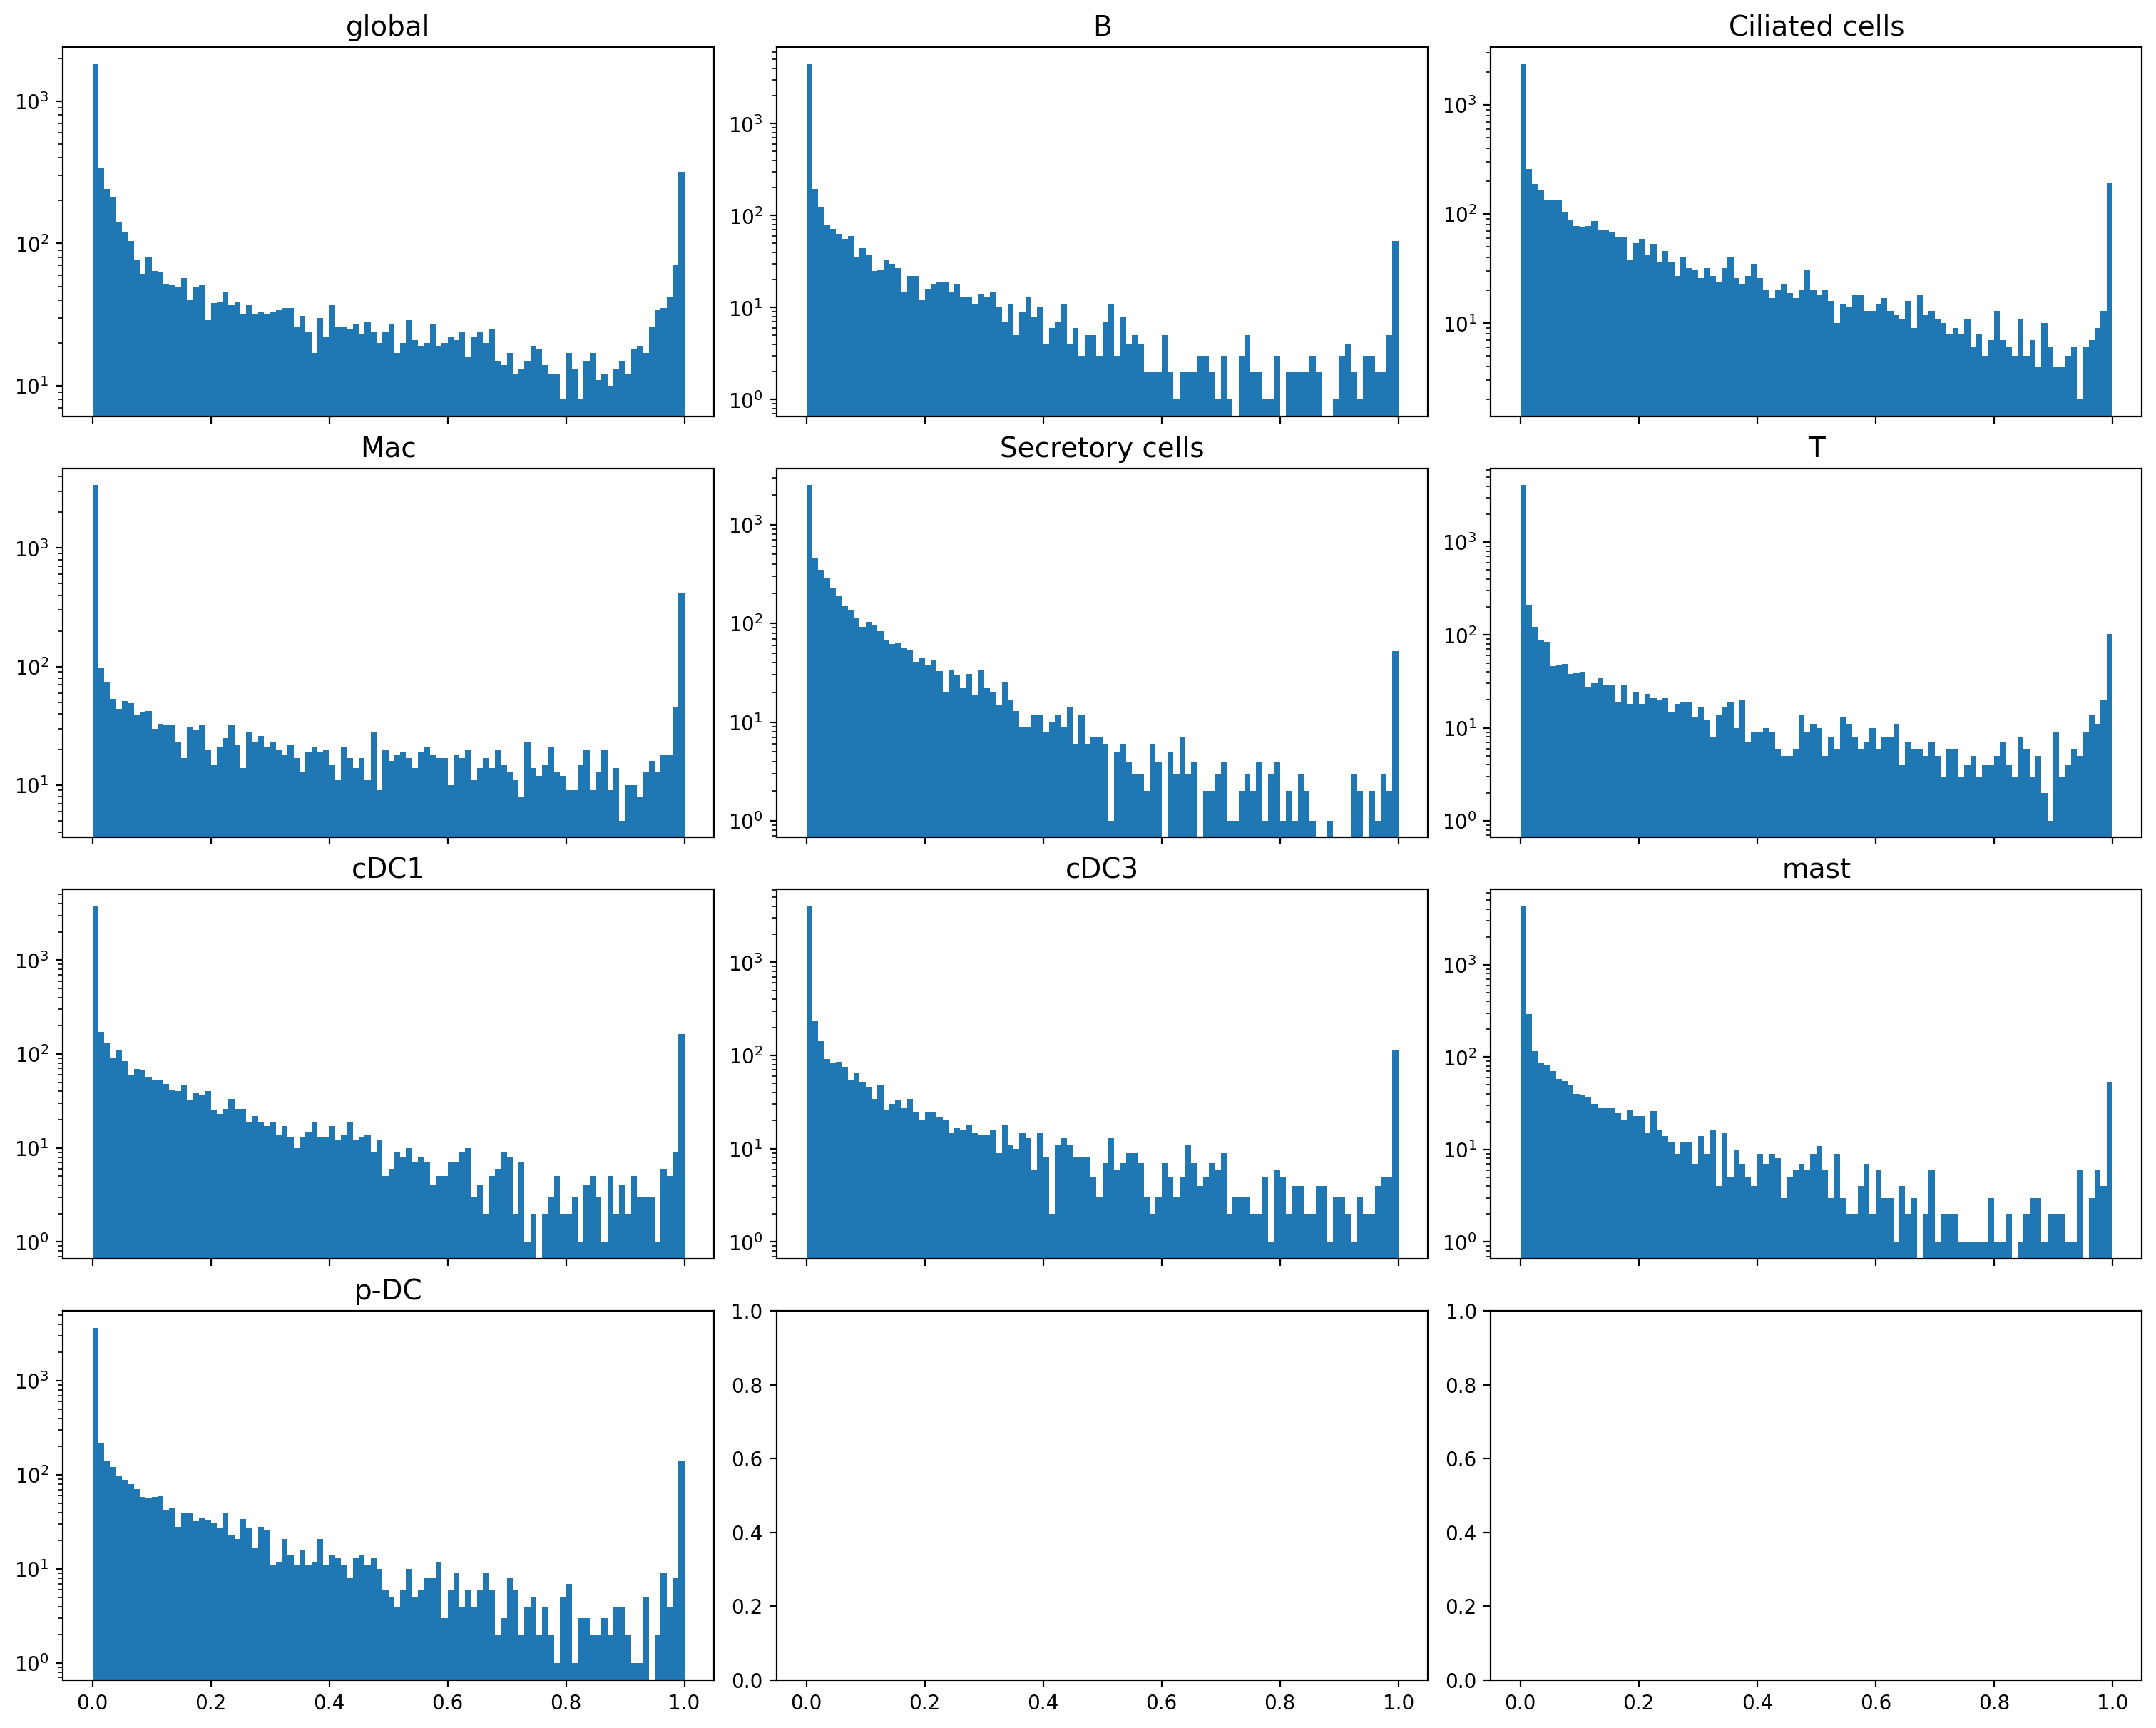

In [ ]:
fig, axes = plt.subplots(
    nrows=4,
    ncols=3,
    figsize=(15, 12),
    constrained_layout=True,
    sharex=True
)
for i, k in enumerate(gene_scalings.keys()):
    x, y = i % 3, i // 3
    ax = axes[y, x]
    ax.hist(gene_scalings[k], bins=100)
    ax.set_yscale("log")
    ax.set_title(k, fontsize=14)

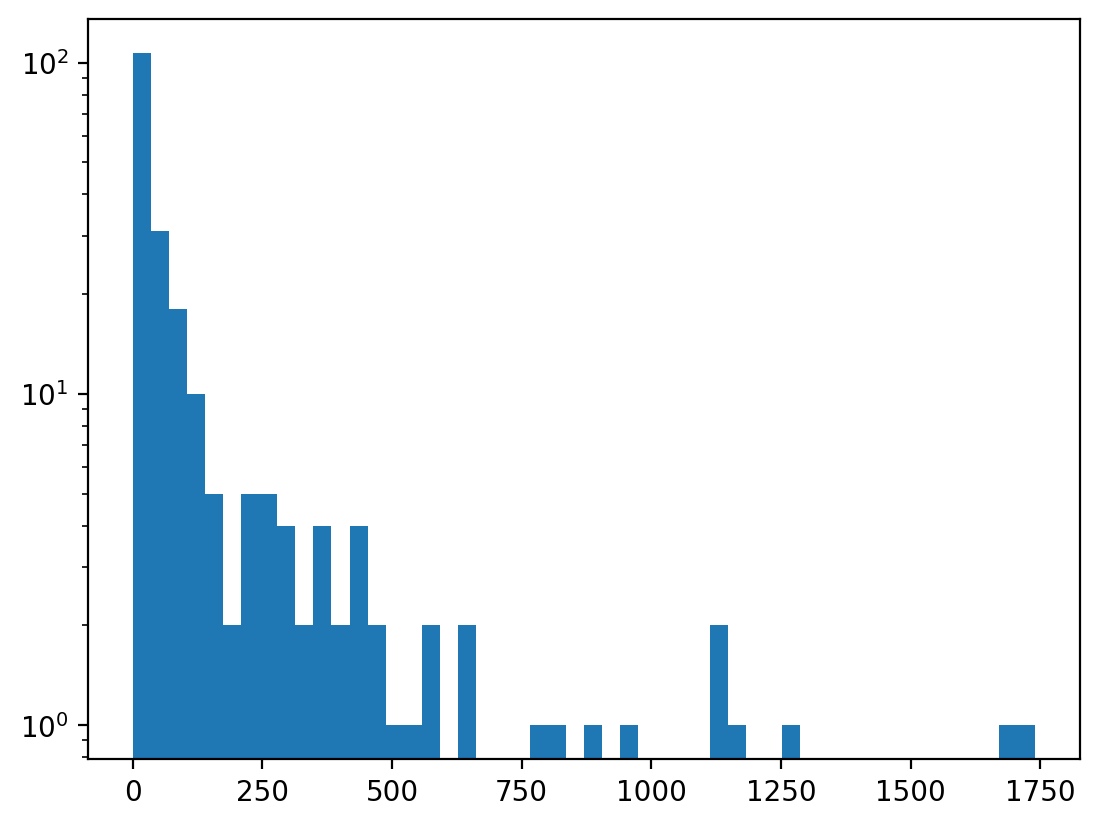

In [127]:
plt.hist(cell_scores.sum(), bins=50, log=True);

## Explore spectra factors

### 1. Gene importance per factor

Let's see the global structure of factors by their gene importance. Let's compute gene weights per factor correlations. I use Pearson correlation, because the distributions of gene weights per factor are pretty comparable, but maybe I'm wrong here. The picture for Spearman correlation looks very different.

I also use `ward` linkage as before, it defines groups better imho.

Gene weights distributions:

Text(0.5, 1.0, 'Gene weights maximum across factors')

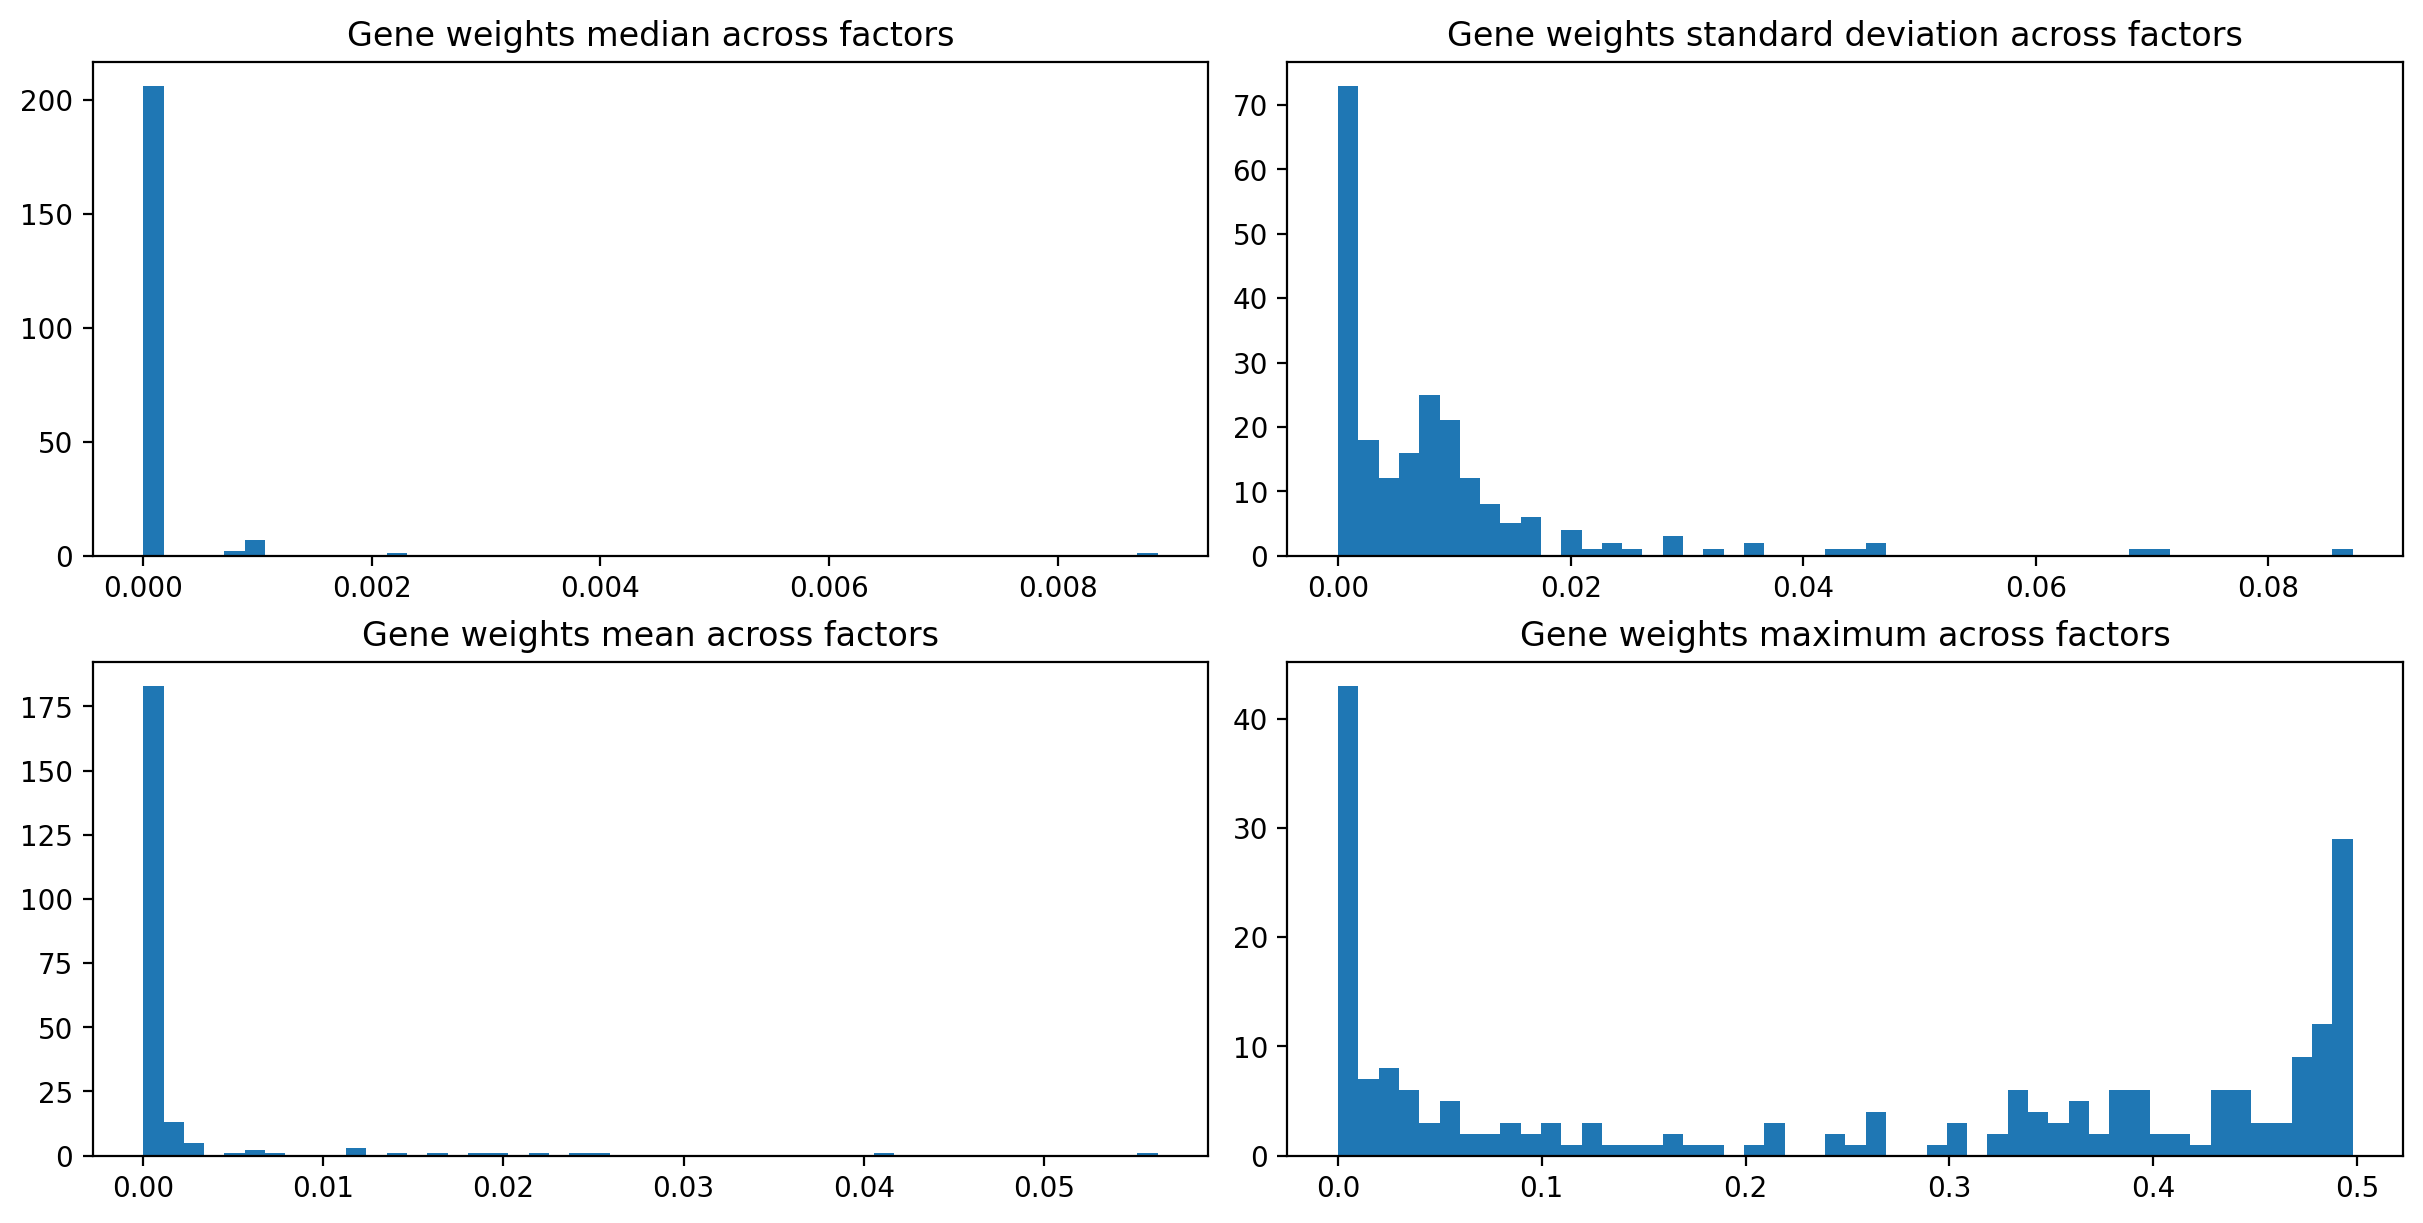

In [128]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6), constrained_layout=True)
axes[0, 0].hist(gene_weights.median(), bins=50)
axes[0, 0].set_title("Gene weights median across factors")
axes[1, 0].hist(gene_weights.mean(), bins=50)
axes[1, 0].set_title("Gene weights mean across factors")
axes[0, 1].hist(gene_weights.std(), bins=50)
axes[0, 1].set_title("Gene weights standard deviation across factors")
axes[1, 1].hist(gene_weights.max(), bins=50)
axes[1, 1].set_title("Gene weights maximum across factors")

In [129]:
factor_gene_corrs = gene_weights.corr(method='pearson')

In [ ]:
factor_celltype_df = pd.DataFrame(
    pd.Series(factor_celltypes).sort_index().values,
    index=factor_gene_corrs.index,
    columns=['cell_type']
)

In [131]:
col_colors = get_color_annotations(factor_celltype_df, {
    'cell_type': 'tab20'
})

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/spectra_venv/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/spectra_venv/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 1.0, 'Gene weights Pearson correlations, ward linkage')

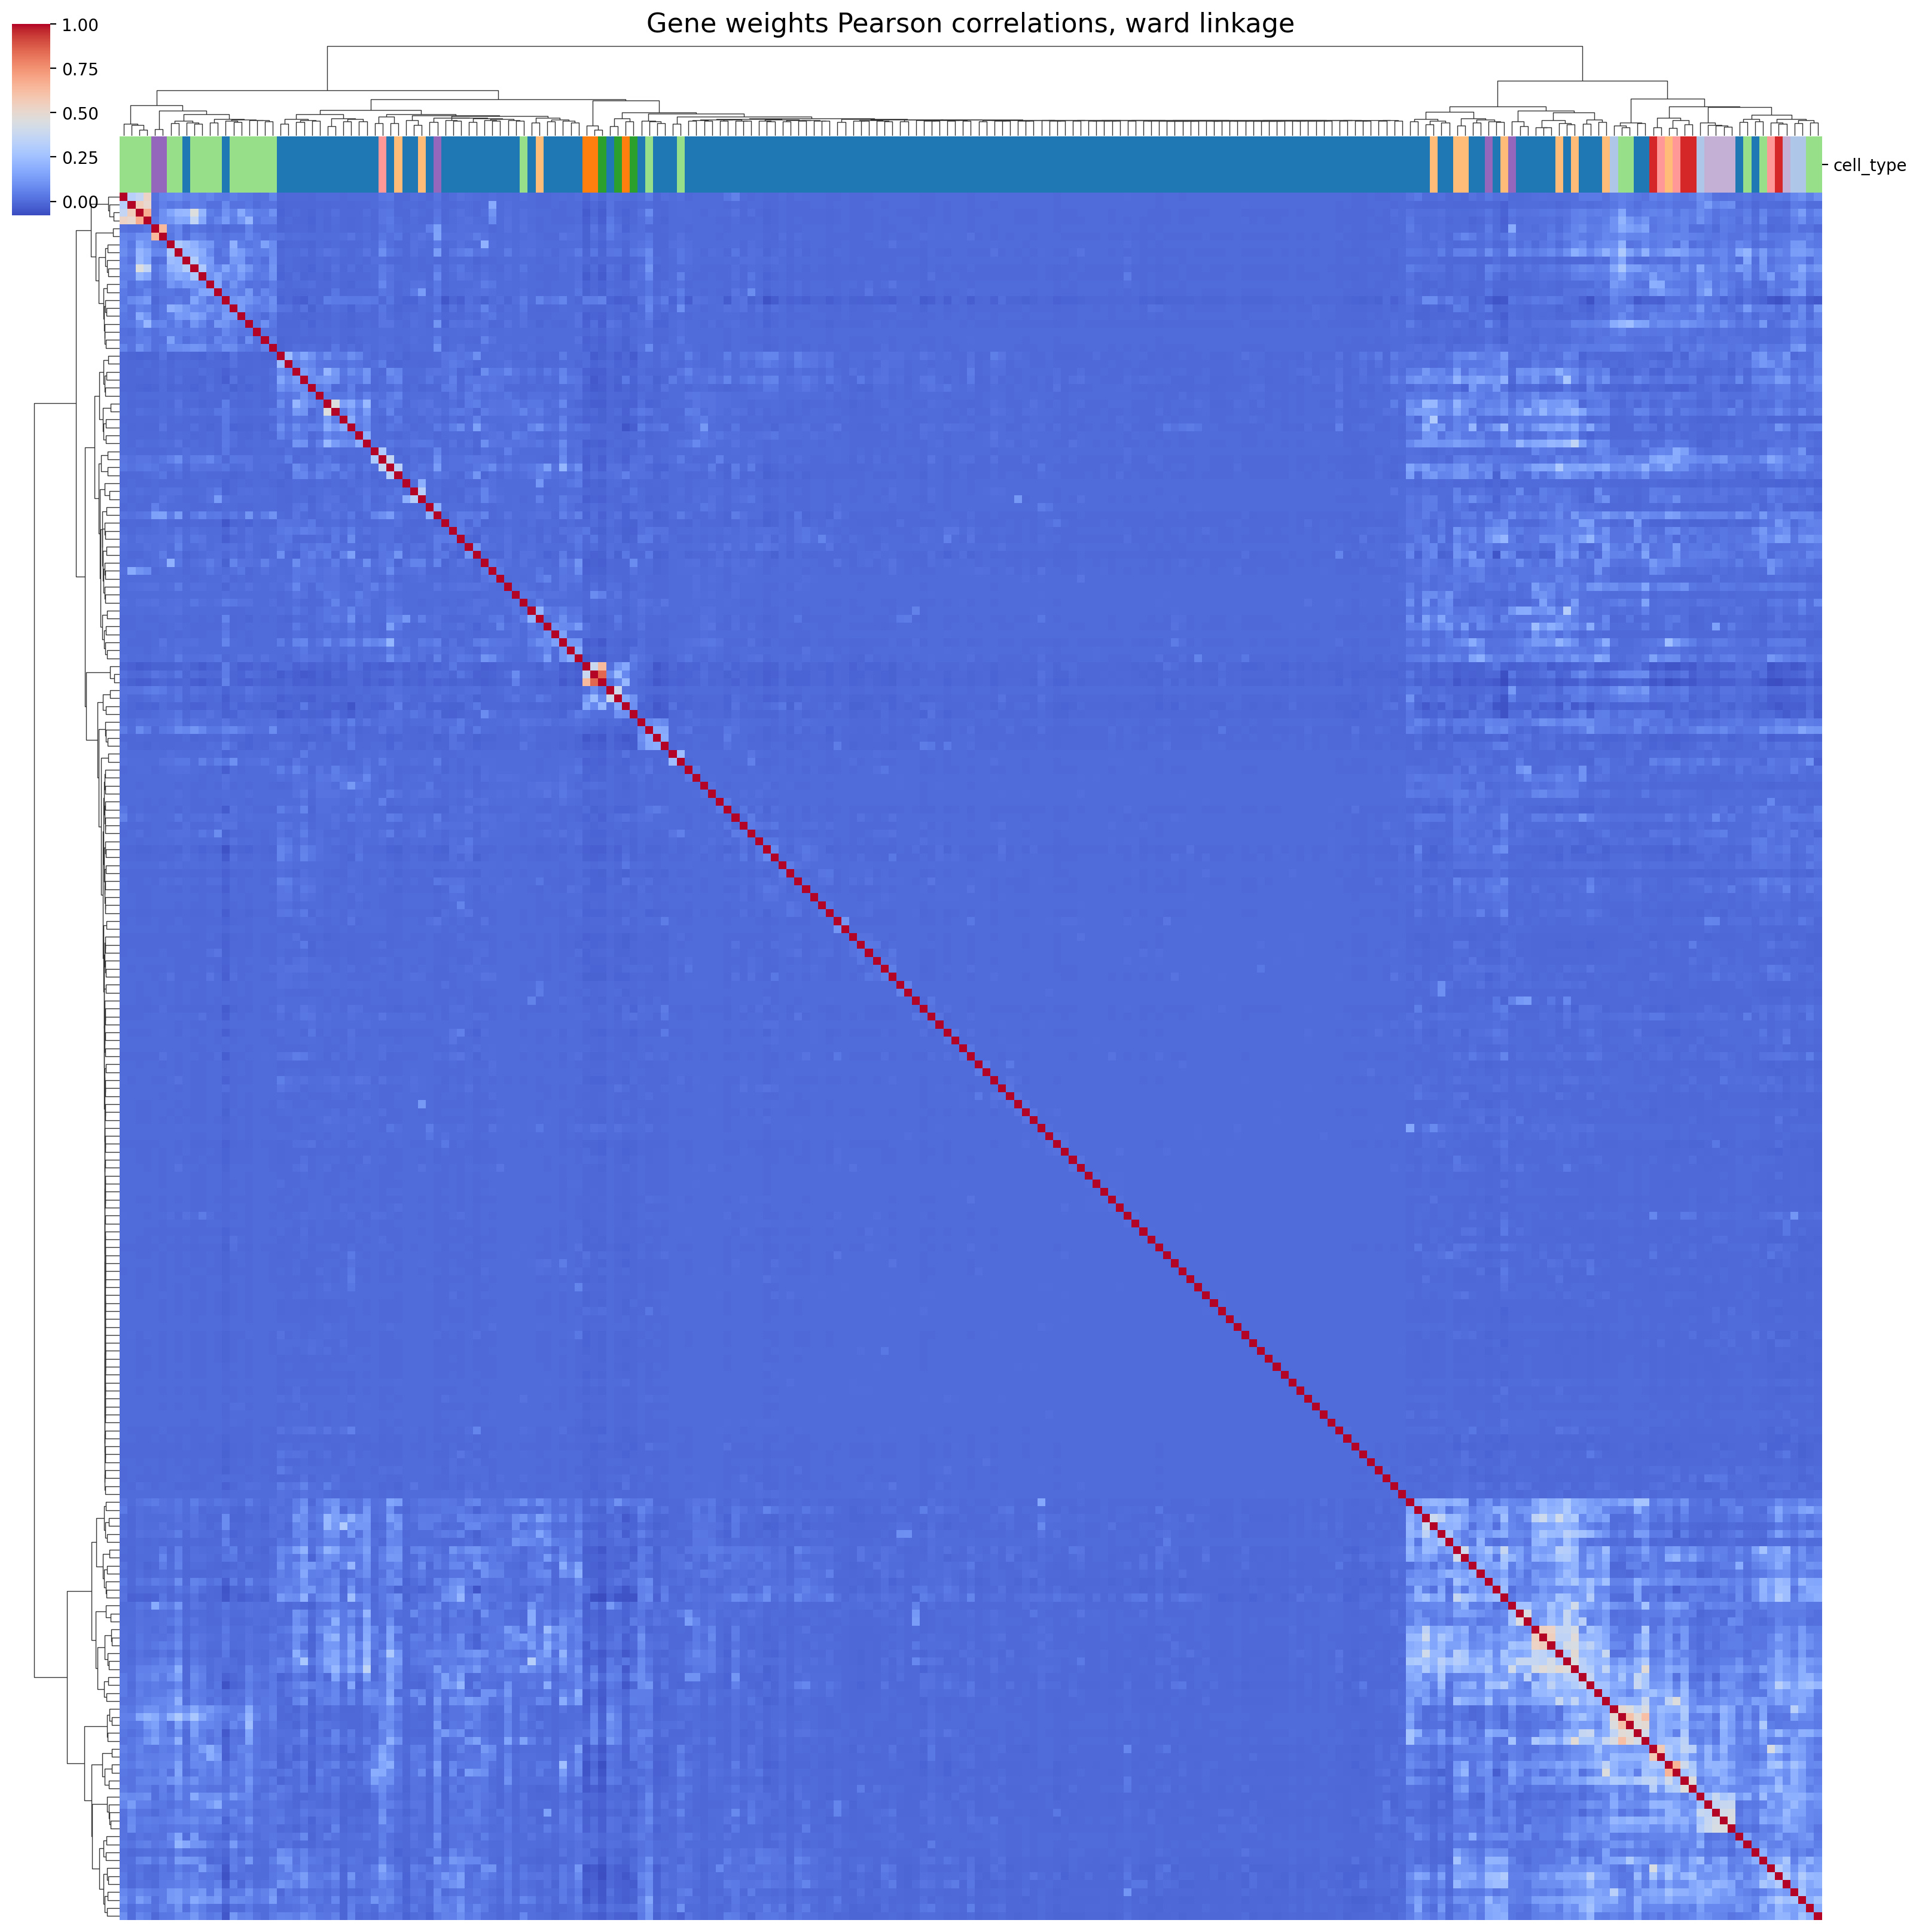

In [ ]:
cg = sns.clustermap(
    factor_gene_corrs,
#     annot=True,
    cmap='coolwarm',
    method='ward',
    col_colors=col_colors,
    # ax=ax,
#     cbar=None,
#     fmt=".3f",
    dendrogram_ratio=0.05,
#     cbar_pos=None,
    figsize=(16, 16),
    xticklabels=[],
    yticklabels=[]
#     annot_kws={"size": 8}
)
p = cg.ax_cbar.get_position()
p.x0 = 0
p.x1 = 0.02
p.y0 = 0.9
p.y1 = 1
cg.ax_cbar.set_position(p)
cg.ax_col_dendrogram.set_title("Gene weights Pearson correlations, ward linkage", size=16)

In [133]:
factor_gene_corrs = gene_weights.corr(method='spearman')

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/spectra_venv/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/spectra_venv/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 1.0, 'Gene weights Spearman correlations, ward linkage')

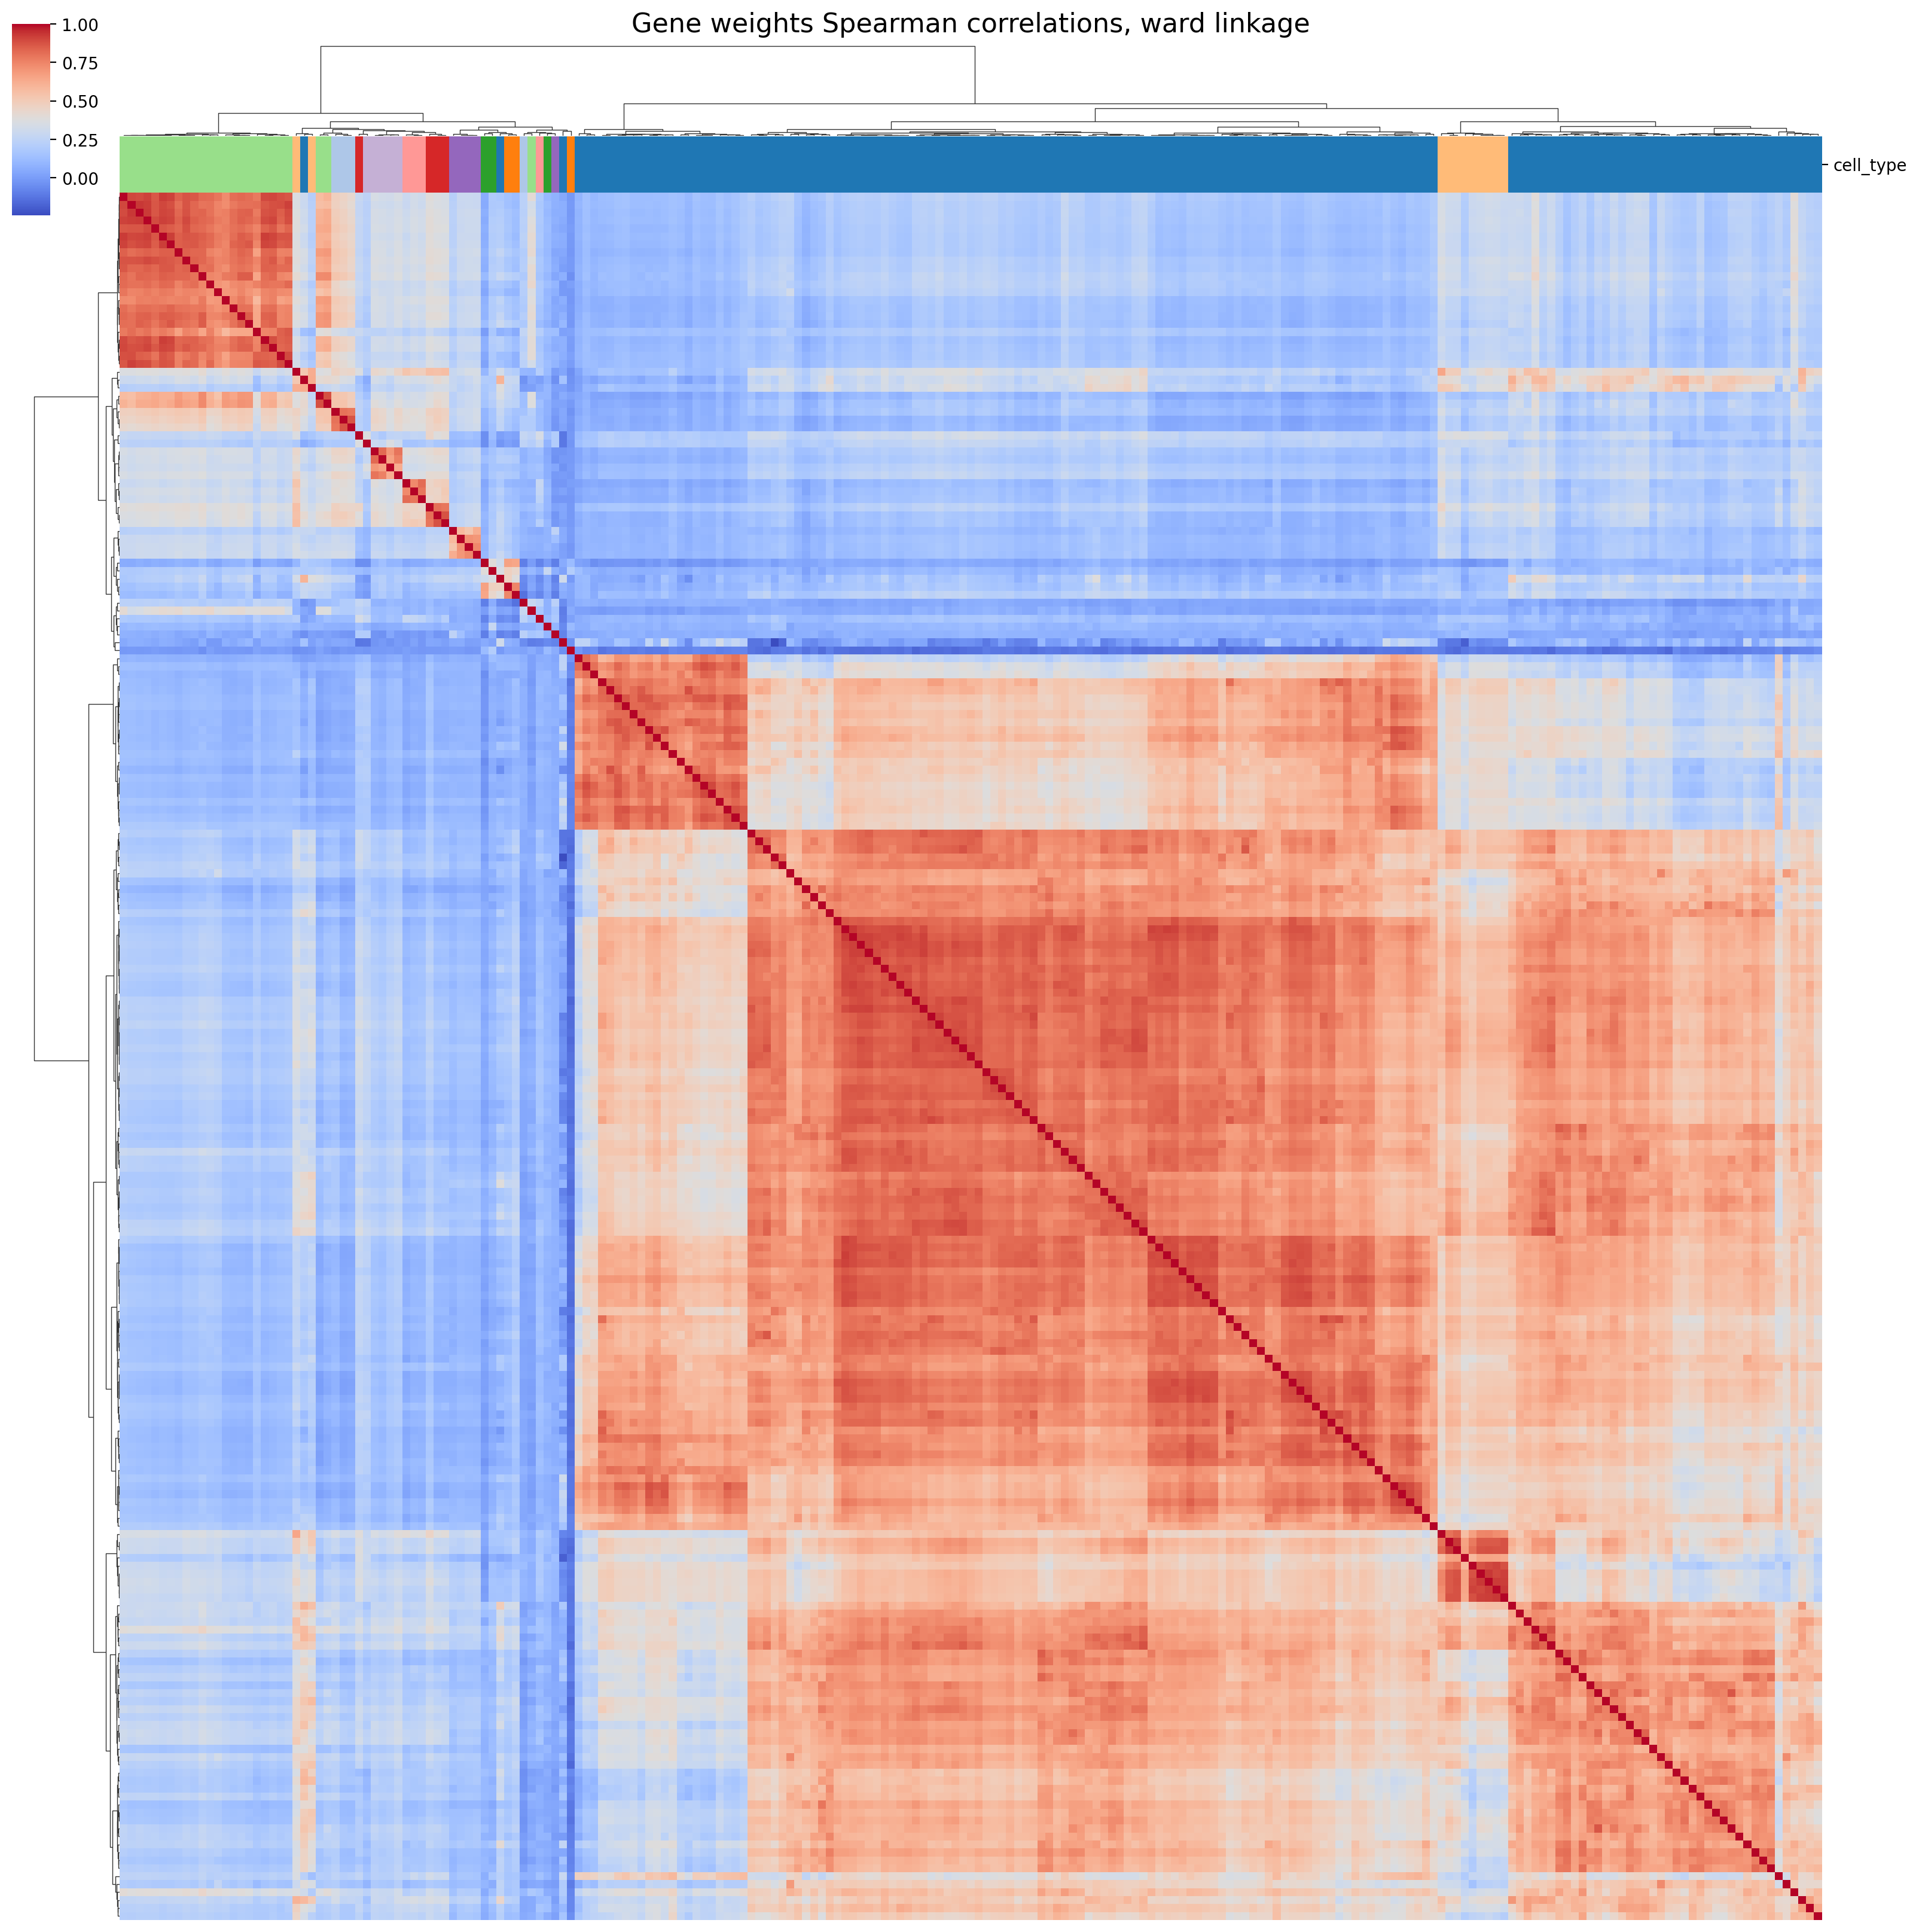

In [ ]:
cg = sns.clustermap(
    factor_gene_corrs,
#     annot=True,
    cmap='coolwarm',
    method='ward',
    col_colors=col_colors,
    # ax=ax,
#     cbar=None,
#     fmt=".3f",
    dendrogram_ratio=0.05,
#     cbar_pos=None,
    figsize=(16, 16),
    xticklabels=[],
    yticklabels=[]
#     annot_kws={"size": 8}
)
p = cg.ax_cbar.get_position()
p.x0 = 0
p.x1 = 0.02
p.y0 = 0.9
p.y1 = 1
cg.ax_cbar.set_position(p)
cg.ax_col_dendrogram.set_title("Gene weights Spearman correlations, ward linkage", size=16)

### 2. Factor activity per cell

Let's see the global structure of factors by their activity in cells. Also using correlations. I use Pearson correlation, because the distributions of gene weights per factor are pretty comparable, but maybe I'm wrong here. The picture for Spearman correlation looks very different.

I also use `ward` linkage as before, it defines groups better imho.

**NB** One additional thing is that visually many factors map to same place as higher nUMI. This makes sense, as with higher nUMI you detect more genes, and thus programs. Let's examine this too.

Text(0.5, 1.0, 'Cell scores maximum across factors')

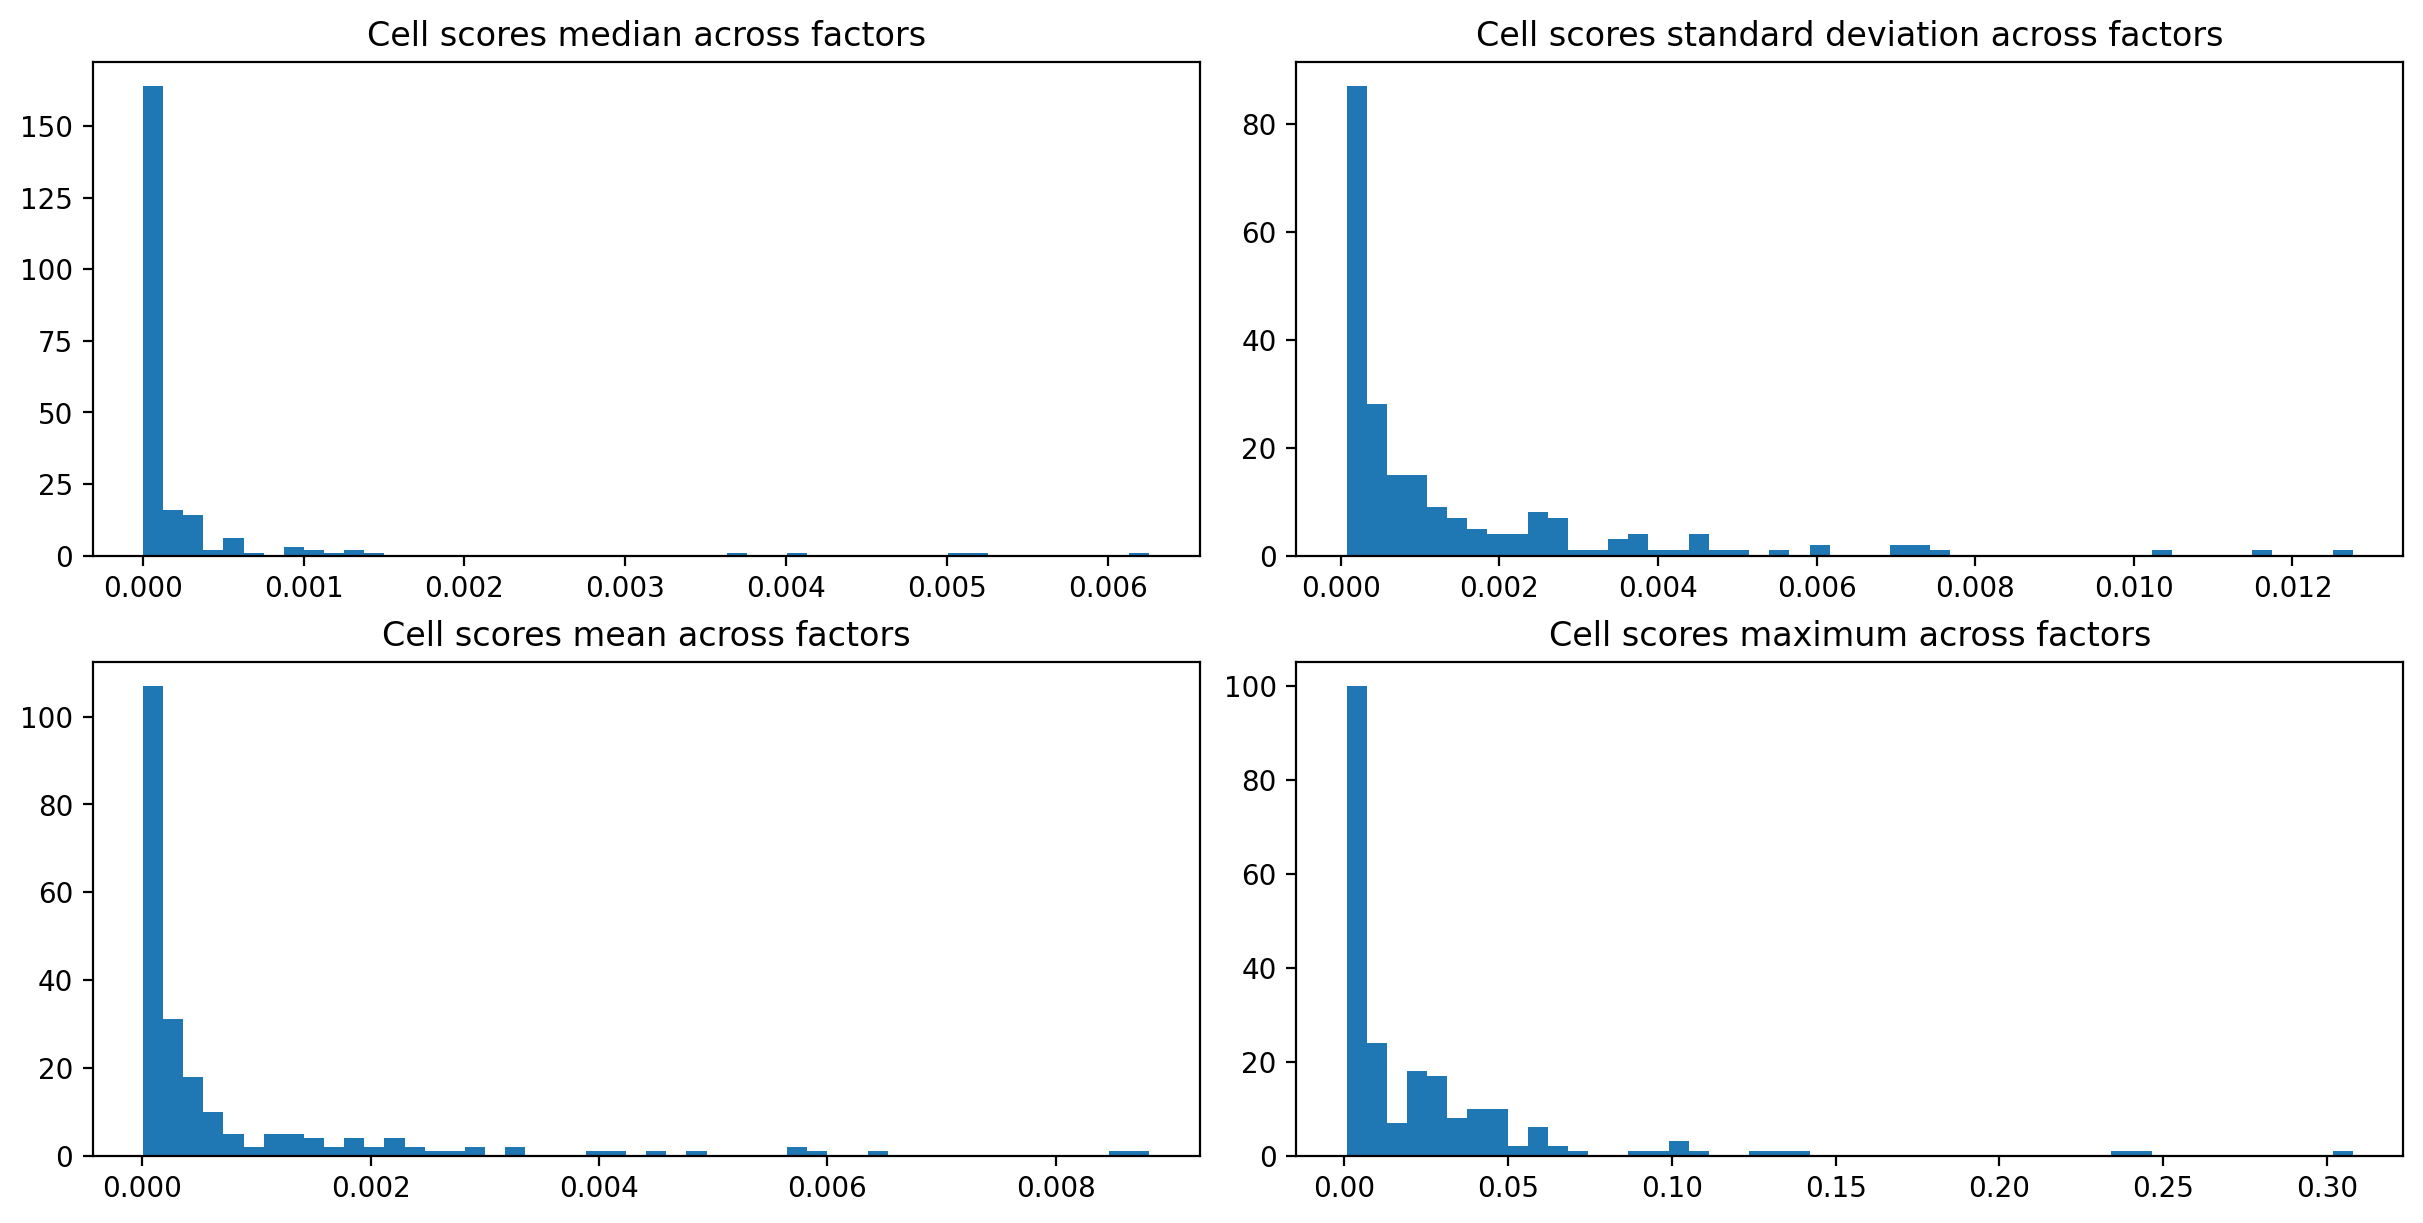

In [135]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6), constrained_layout=True)
axes[0, 0].hist(cell_scores.median(), bins=50)
axes[0, 0].set_title("Cell scores median across factors")
axes[1, 0].hist(cell_scores.mean(), bins=50)
axes[1, 0].set_title("Cell scores mean across factors")
axes[0, 1].hist(cell_scores.std(), bins=50)
axes[0, 1].set_title("Cell scores standard deviation across factors")
axes[1, 1].hist(cell_scores.max(), bins=50)
axes[1, 1].set_title("Cell scores maximum across factors")

Text(0.5, 1.0, 'Sorted standard deviations across factors')

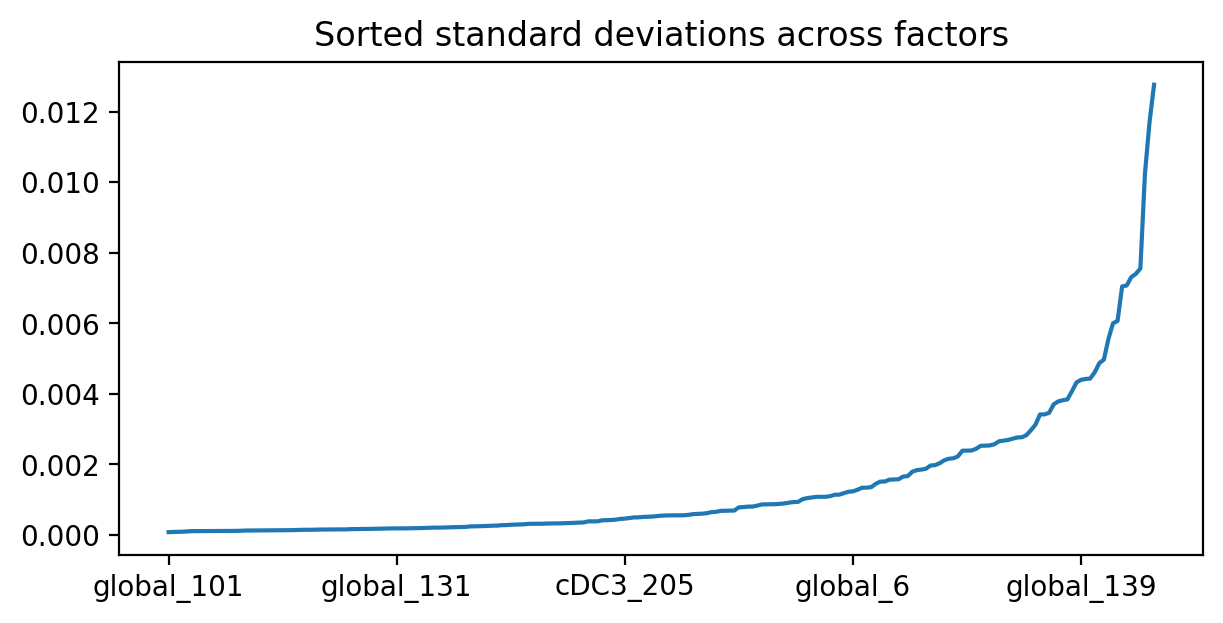

In [136]:
fig, ax = plt.subplots(figsize=(6, 3), constrained_layout=True)
cell_scores.std().sort_values().plot(ax=ax)
ax.set_title("Sorted standard deviations across factors")

In [137]:
cell_scores2 = cell_scores.copy()

In [138]:
cell_scores2["nUMI"] = adata.obs.total_counts

In [139]:
factor_cell_corrs = cell_scores2.corr(method='pearson')

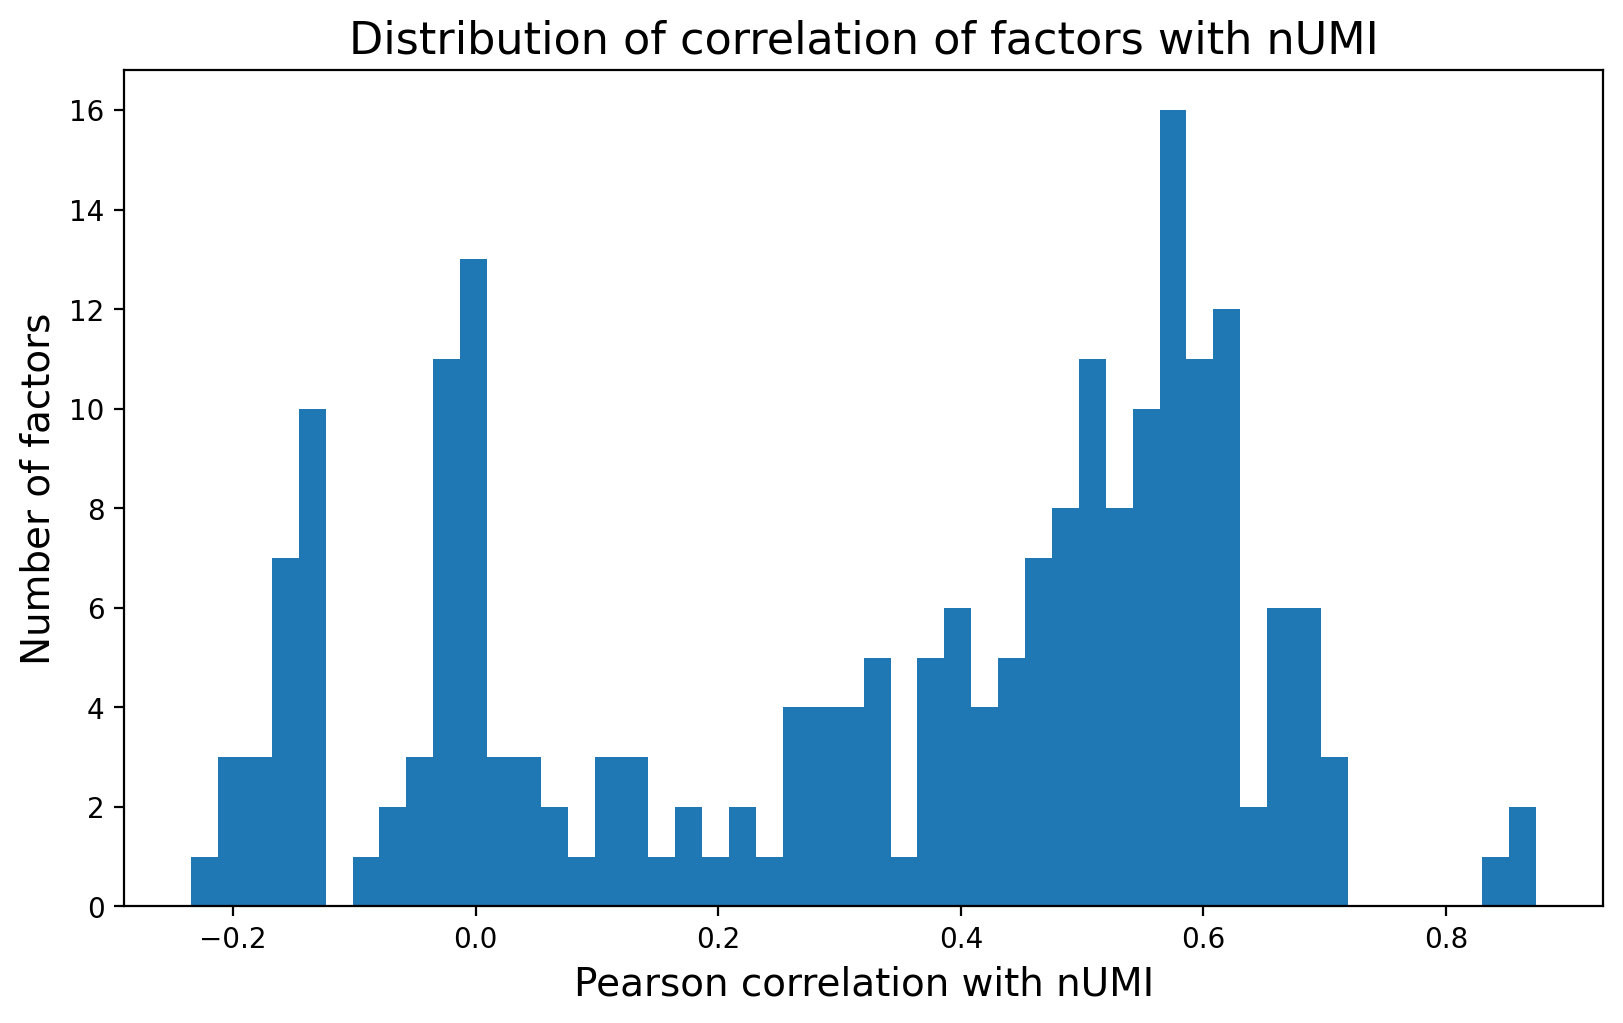

In [140]:
fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
ax.hist(factor_cell_corrs.nUMI.iloc[:-1], bins=50);
ax.set_title("Distribution of correlation of factors with nUMI", size=16)
ax.set_xlabel("Pearson correlation with nUMI", size=14)
ax.set_ylabel("Number of factors", size=14);

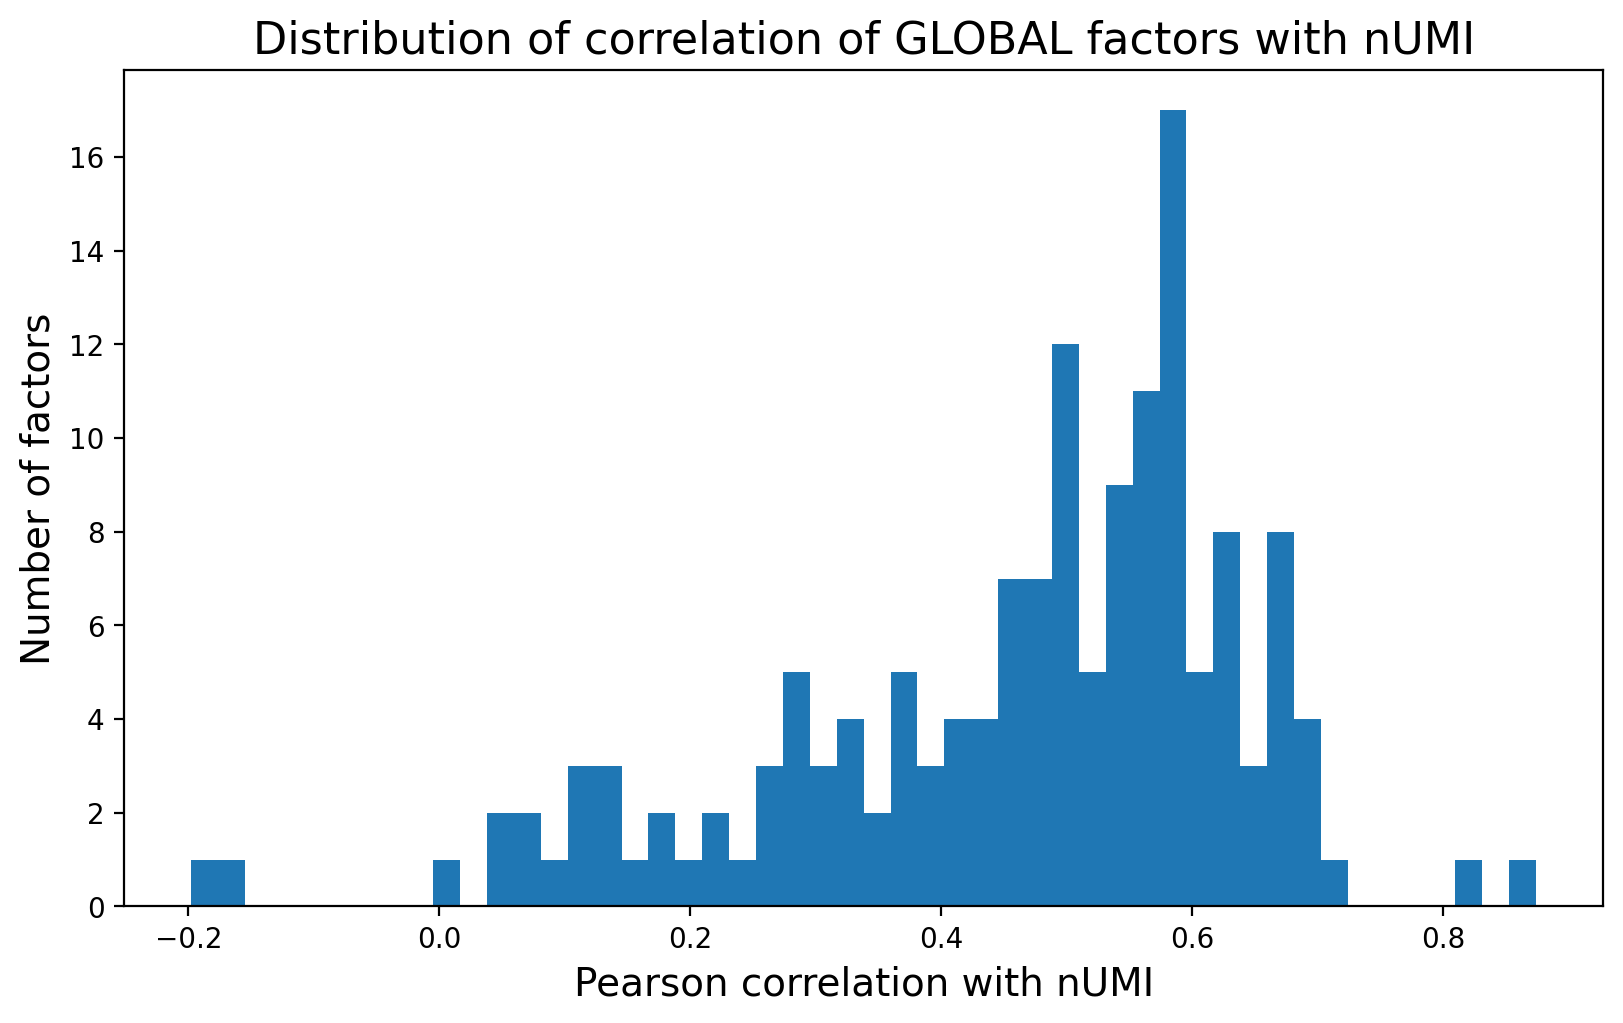

In [141]:
fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
ax.hist(factor_cell_corrs.nUMI.iloc[:-1][factor_celltype_df.cell_type.eq('global').values], bins=50);
ax.set_title("Distribution of correlation of GLOBAL factors with nUMI", size=16)
ax.set_xlabel("Pearson correlation with nUMI", size=14)
ax.set_ylabel("Number of factors", size=14);

**Conclusion**: the majority of Global factors do correlate with nUMIs (sequencing depth)

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/spectra_venv/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/spectra_venv/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 1.0, 'Cell scores Pearson correlations, ward linkage')

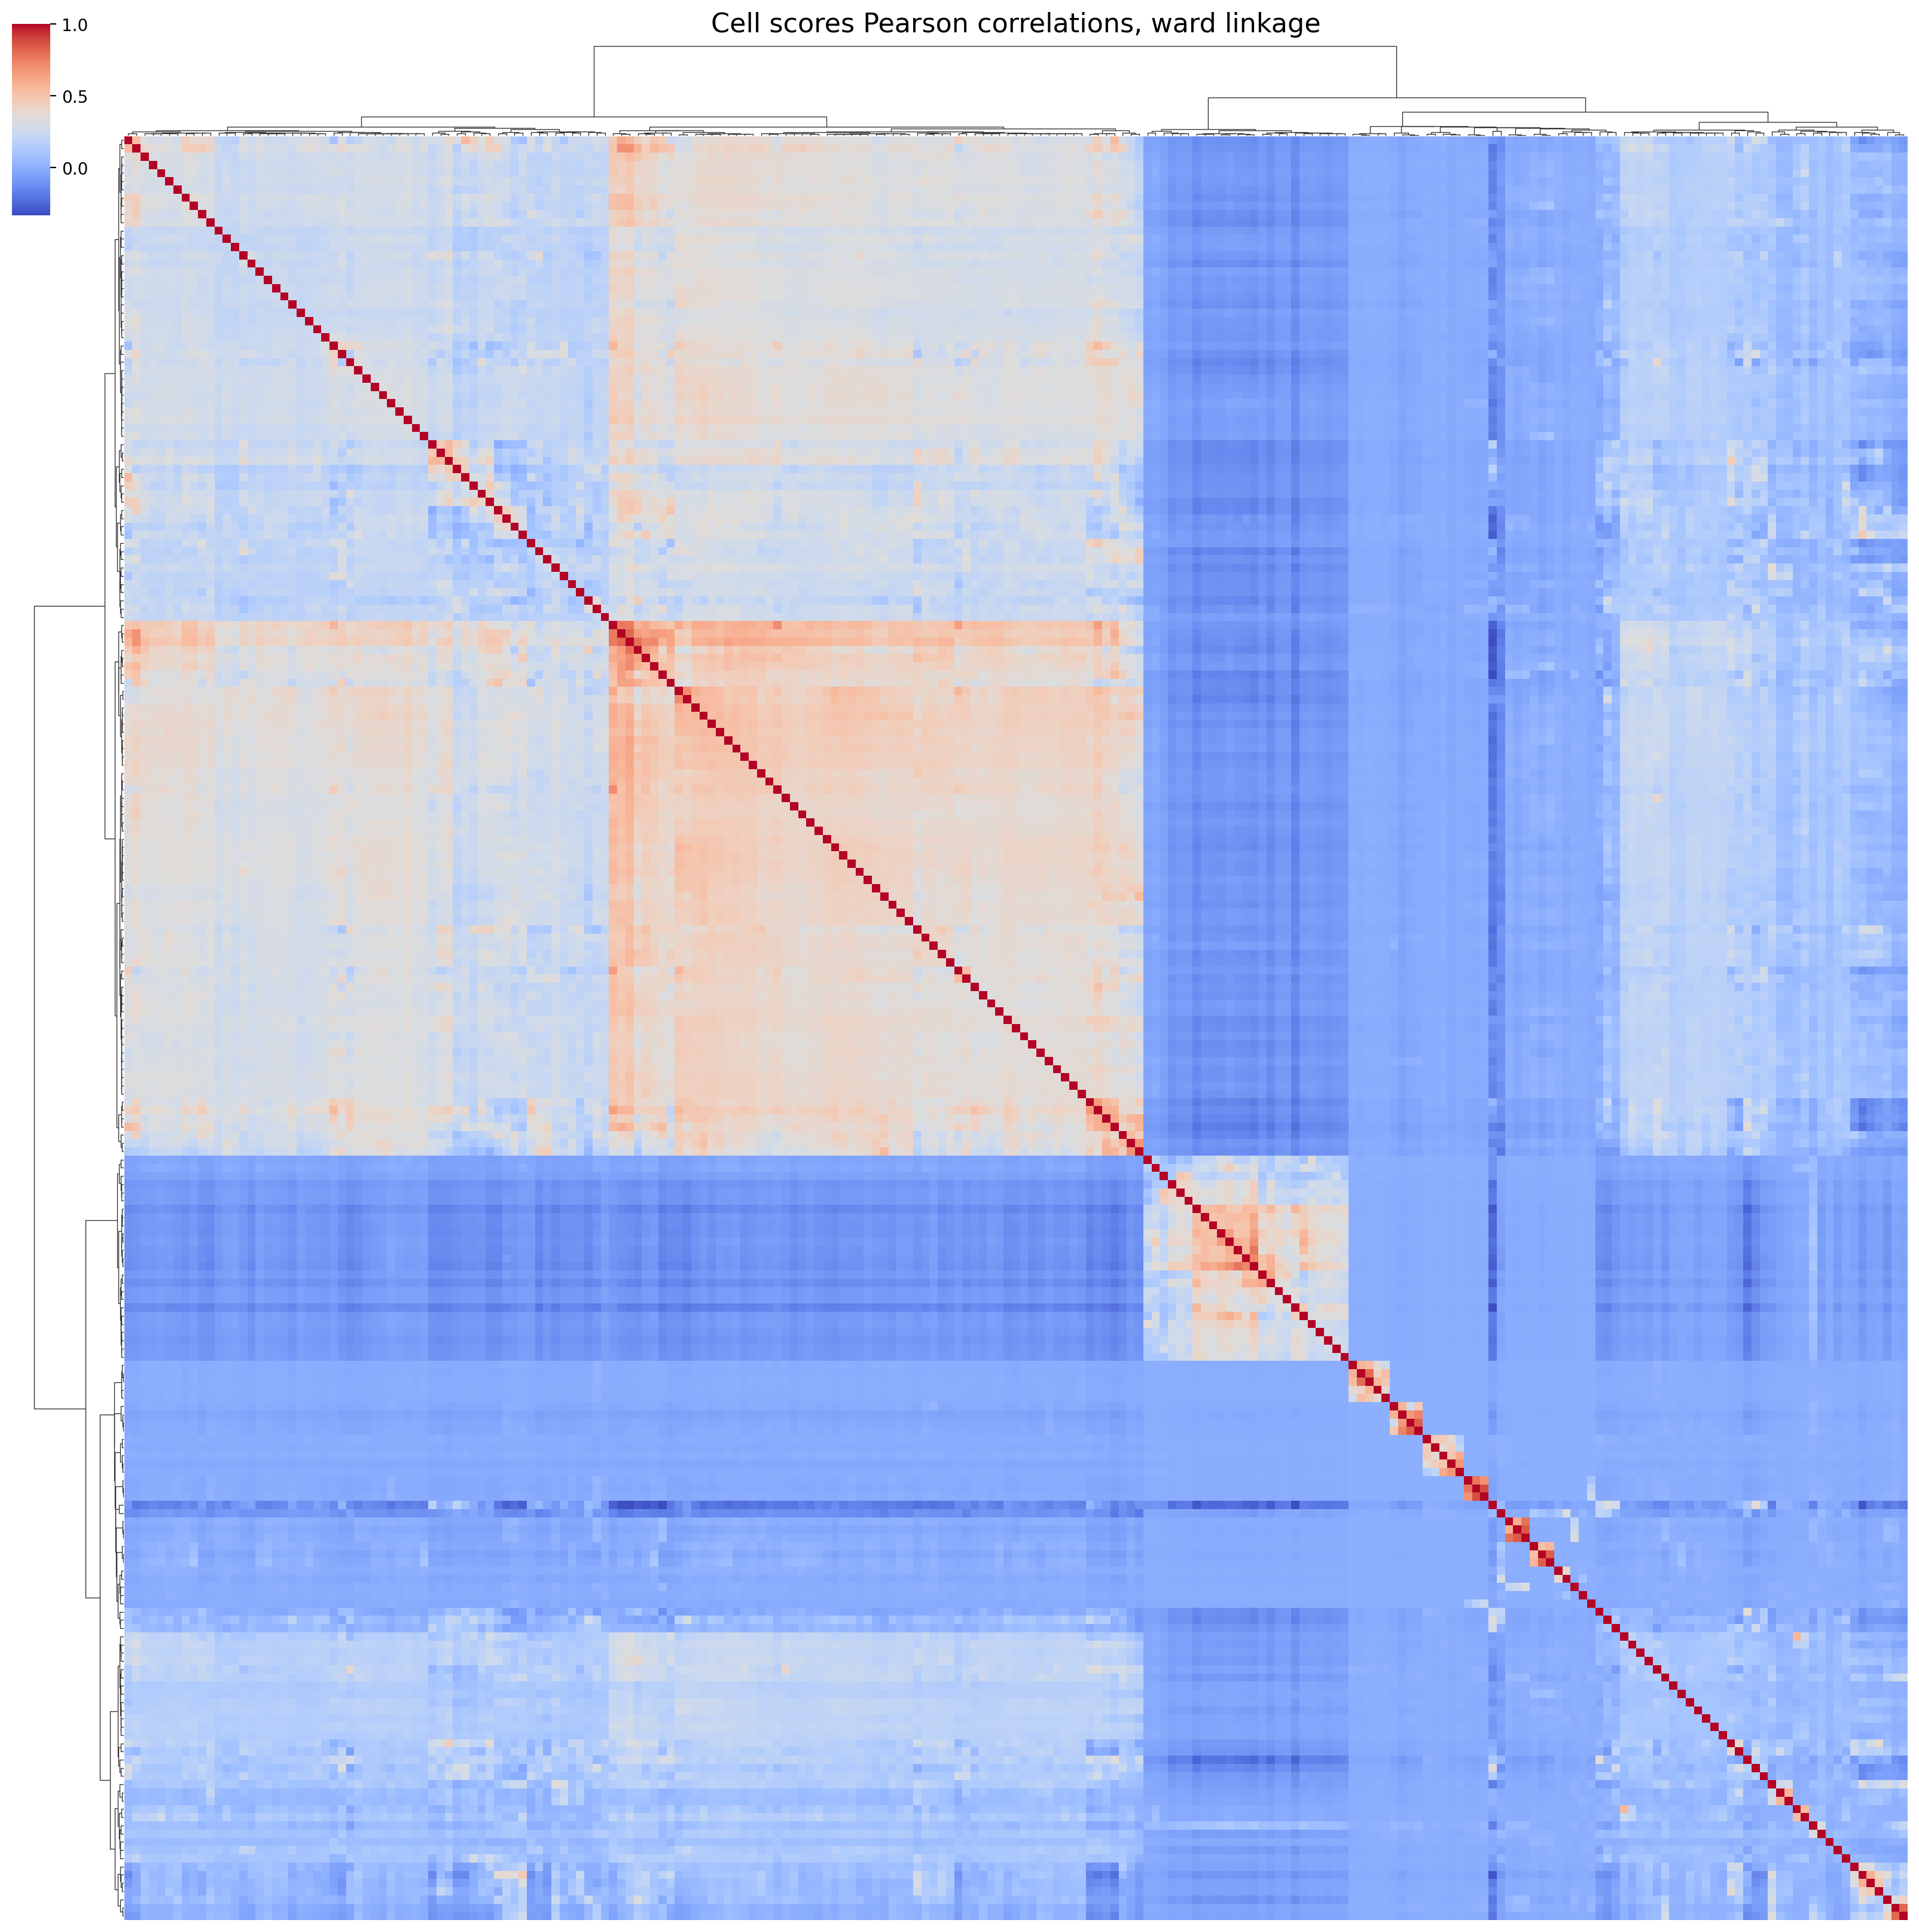

In [ ]:
cg = sns.clustermap(
    factor_cell_corrs.drop(columns=["nUMI"], index=["nUMI"]),
#     annot=True,
    cmap='coolwarm',
    method='ward',
    # ax=ax,
#     cbar=None,
#     fmt=".3f",
    dendrogram_ratio=0.05,
#     cbar_pos=None,
    figsize=(16, 16),
    xticklabels=[],
    yticklabels=[]
#     annot_kws={"size": 8}
)
p = cg.ax_cbar.get_position()
p.x0 = 0
p.x1 = 0.02
p.y0 = 0.9
p.y1 = 1
cg.ax_cbar.set_position(p)
cg.ax_col_dendrogram.set_title("Cell scores Pearson correlations, ward linkage", size=16)

### 3. Finding top factors for cell type

Extremely simple procedure: compute mean factor scores for cell type and all other cells, subtract, sort by difference. Method shows very specific factors but is flawed for factors that show up in cell type of interest and some other cell types.

In [143]:
cell_scores3 = cell_scores.copy()
cell_scores3["cell_type"] = adata.obs.cell_type

In [144]:
cell_type = "Perivascular macrophages"
cell_scores3["is_cell_type"] = cell_scores3.cell_type == cell_type
cell_type_scores = cell_scores3.groupby("is_cell_type").median().T.rename(columns={
    False: f"not {cell_type}",
    True: cell_type
})
cell_type_scores["diff"] = cell_type_scores[cell_type] - cell_type_scores[f"not {cell_type}"]
cell_type_scores.sort_values("diff", ascending=False).head(20)

/tmp/ipykernel_46734/2116634950.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cell_type_scores = cell_scores3.groupby("is_cell_type").median().T.rename(columns={


is_cell_type,not Perivascular macrophages,Perivascular macrophages,diff
Mac_167,0.00000,0.01349,0.01349
global_134,0.00000,0.00747,0.00747
global_142,0.00358,0.01084,0.00726
Mac_166,0.00014,0.00440,0.00426
global_148,0.00000,0.00305,0.00305
global_82,0.00000,0.00277,0.00277
Mac_165,0.00058,0.00291,0.00233
global_96,0.00057,0.00280,0.00223
global_108,0.00001,0.00172,0.00171
global_24,0.00140,0.00307,0.00167


### 4. Look at mean factor score by cell type

Exploratory look at which factors are highlighting which cell types

In [145]:
cell_scores3.drop(columns=["is_cell_type"], inplace=True)

Text(0.5, 1.0, 'Mean factor scores per cell type, ward linkage')

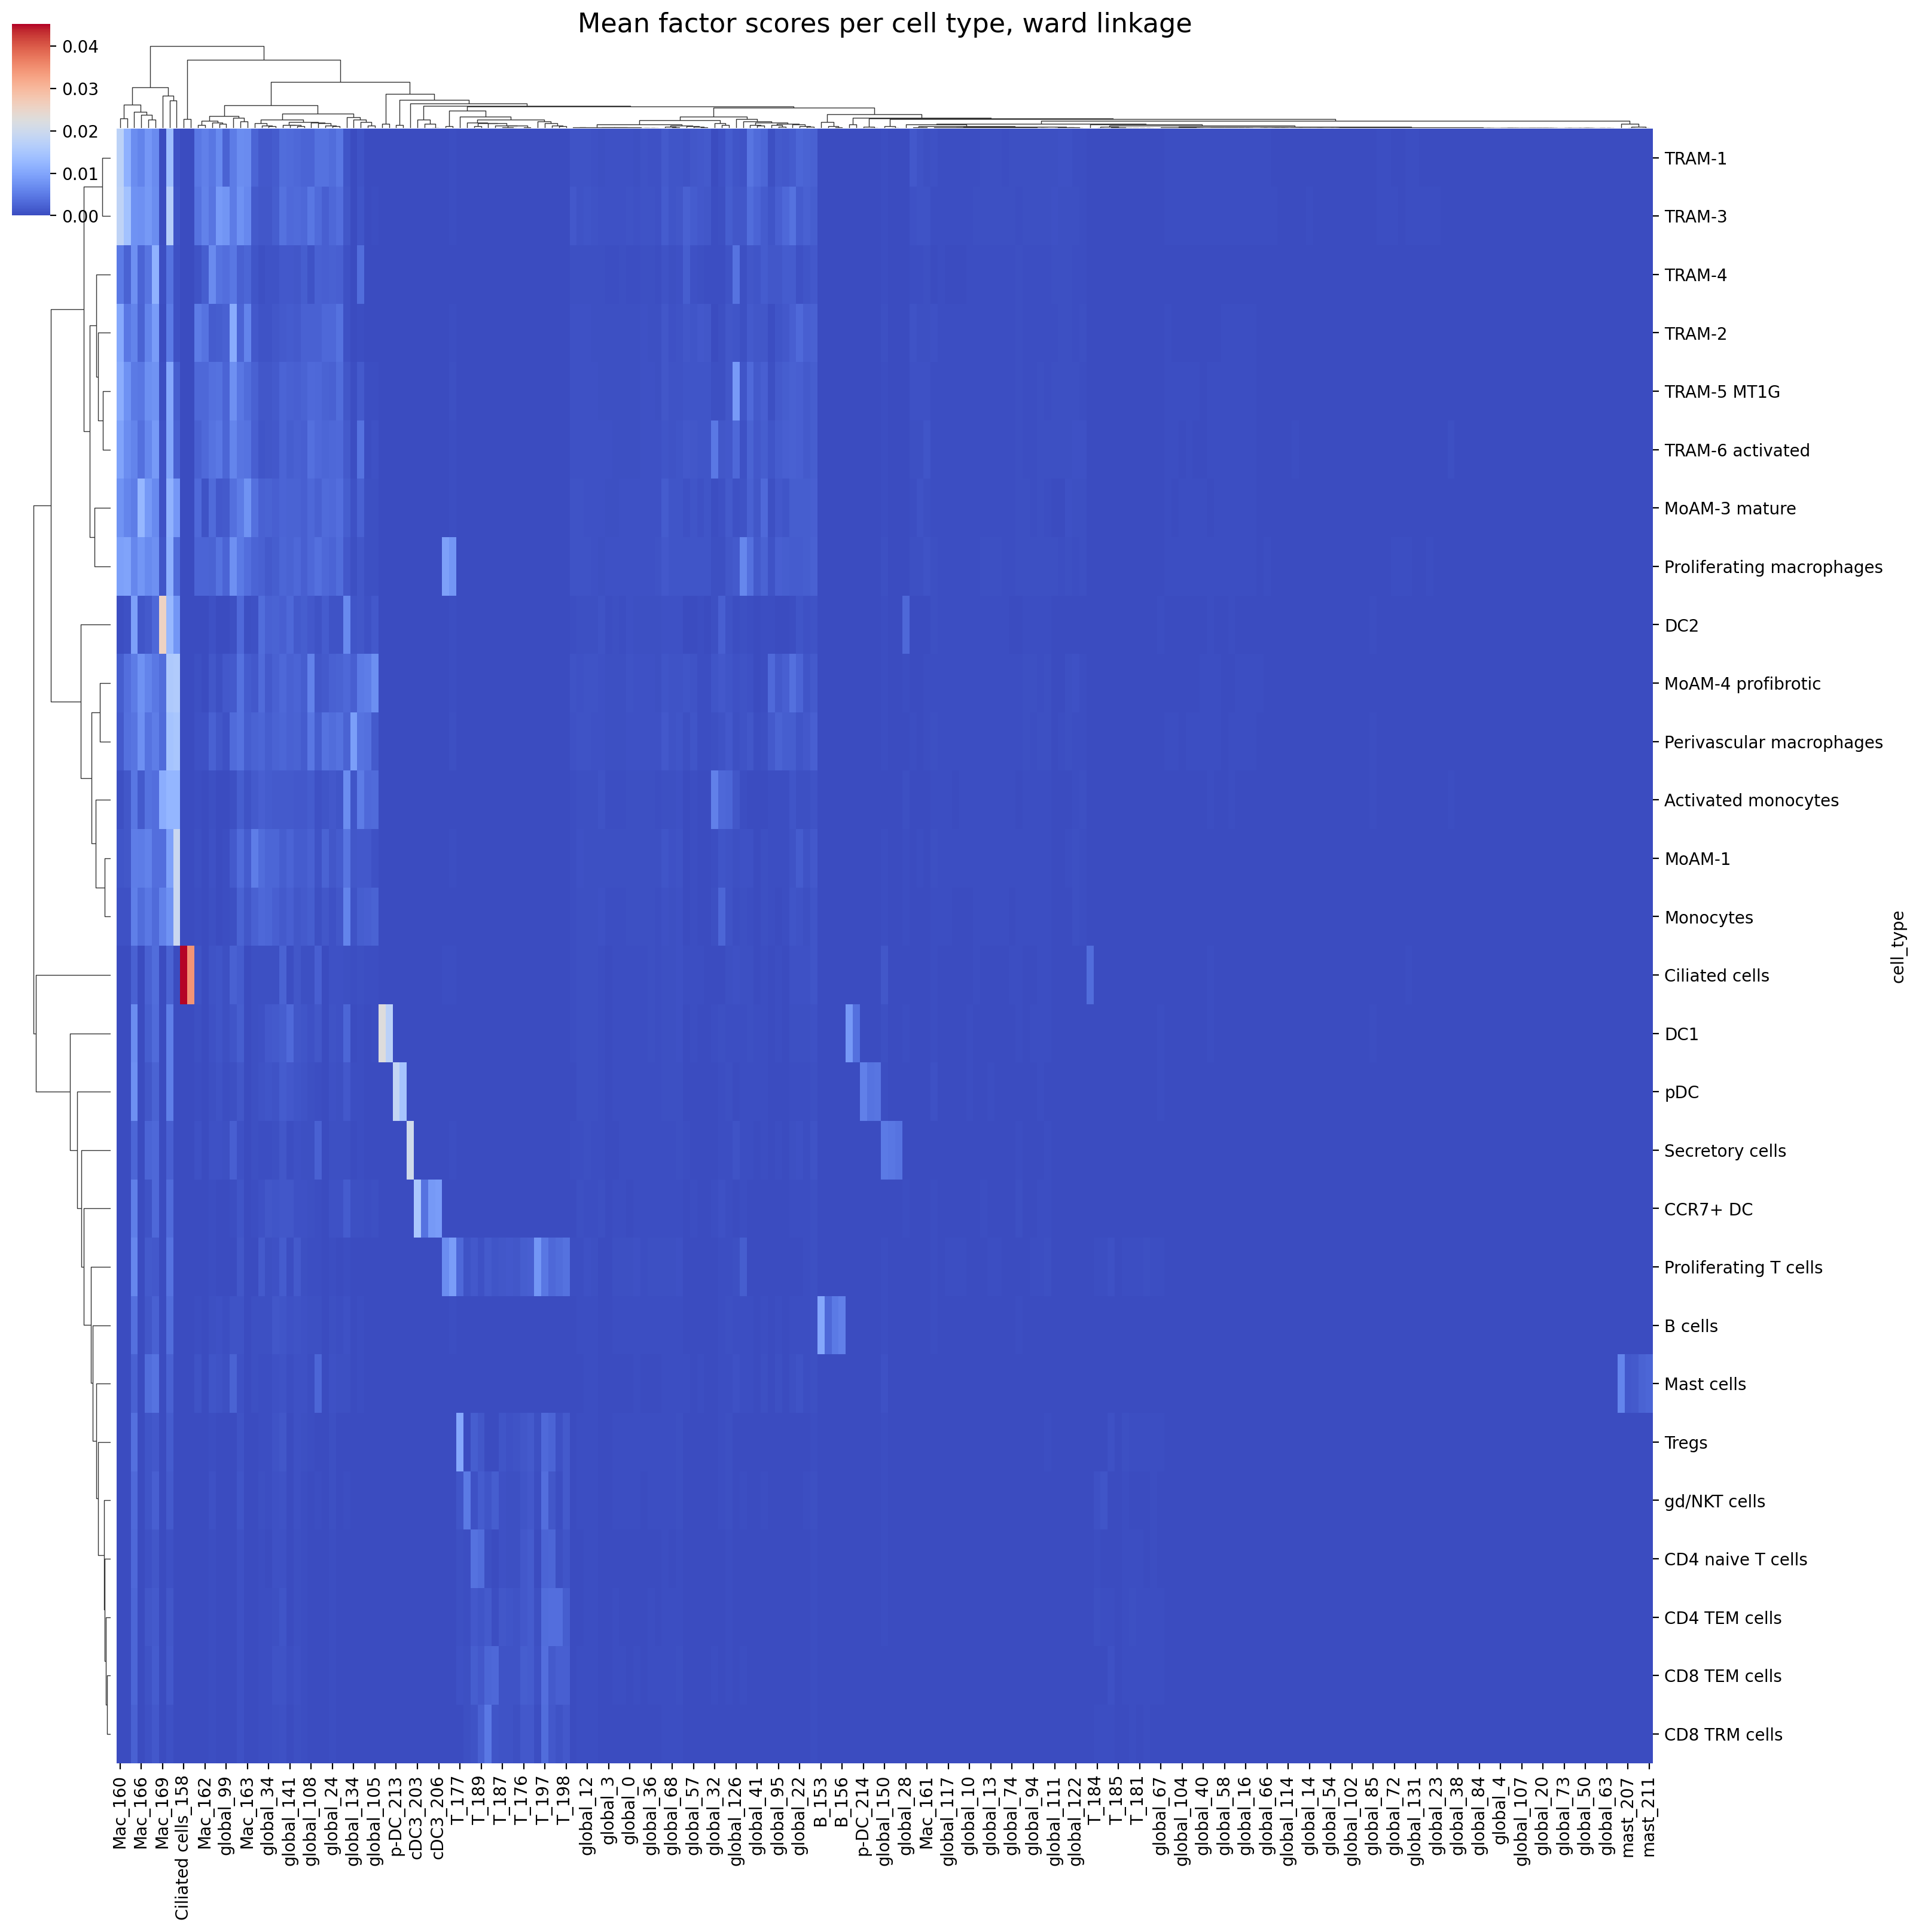

In [ ]:
cg = sns.clustermap(
    cell_scores3.groupby("cell_type").mean(),
#     annot=True,
    cmap='coolwarm',
    method='ward',
    # ax=ax,
#     cbar=None,
#     fmt=".3f",
    dendrogram_ratio=0.05,
#     cbar_pos=None,
    figsize=(16, 16),
#     xticklabels=[],
#     yticklabels=[]
#     annot_kws={"size": 8}
)
p = cg.ax_cbar.get_position()
p.x0 = 0
p.x1 = 0.02
p.y0 = 0.9
p.y1 = 1
cg.ax_cbar.set_position(p)
cg.ax_col_dendrogram.set_title("Mean factor scores per cell type, ward linkage", size=16)

Text(0.5, 1.0, 'Mean factor scores (standard scale) per cell type, ward linkage')

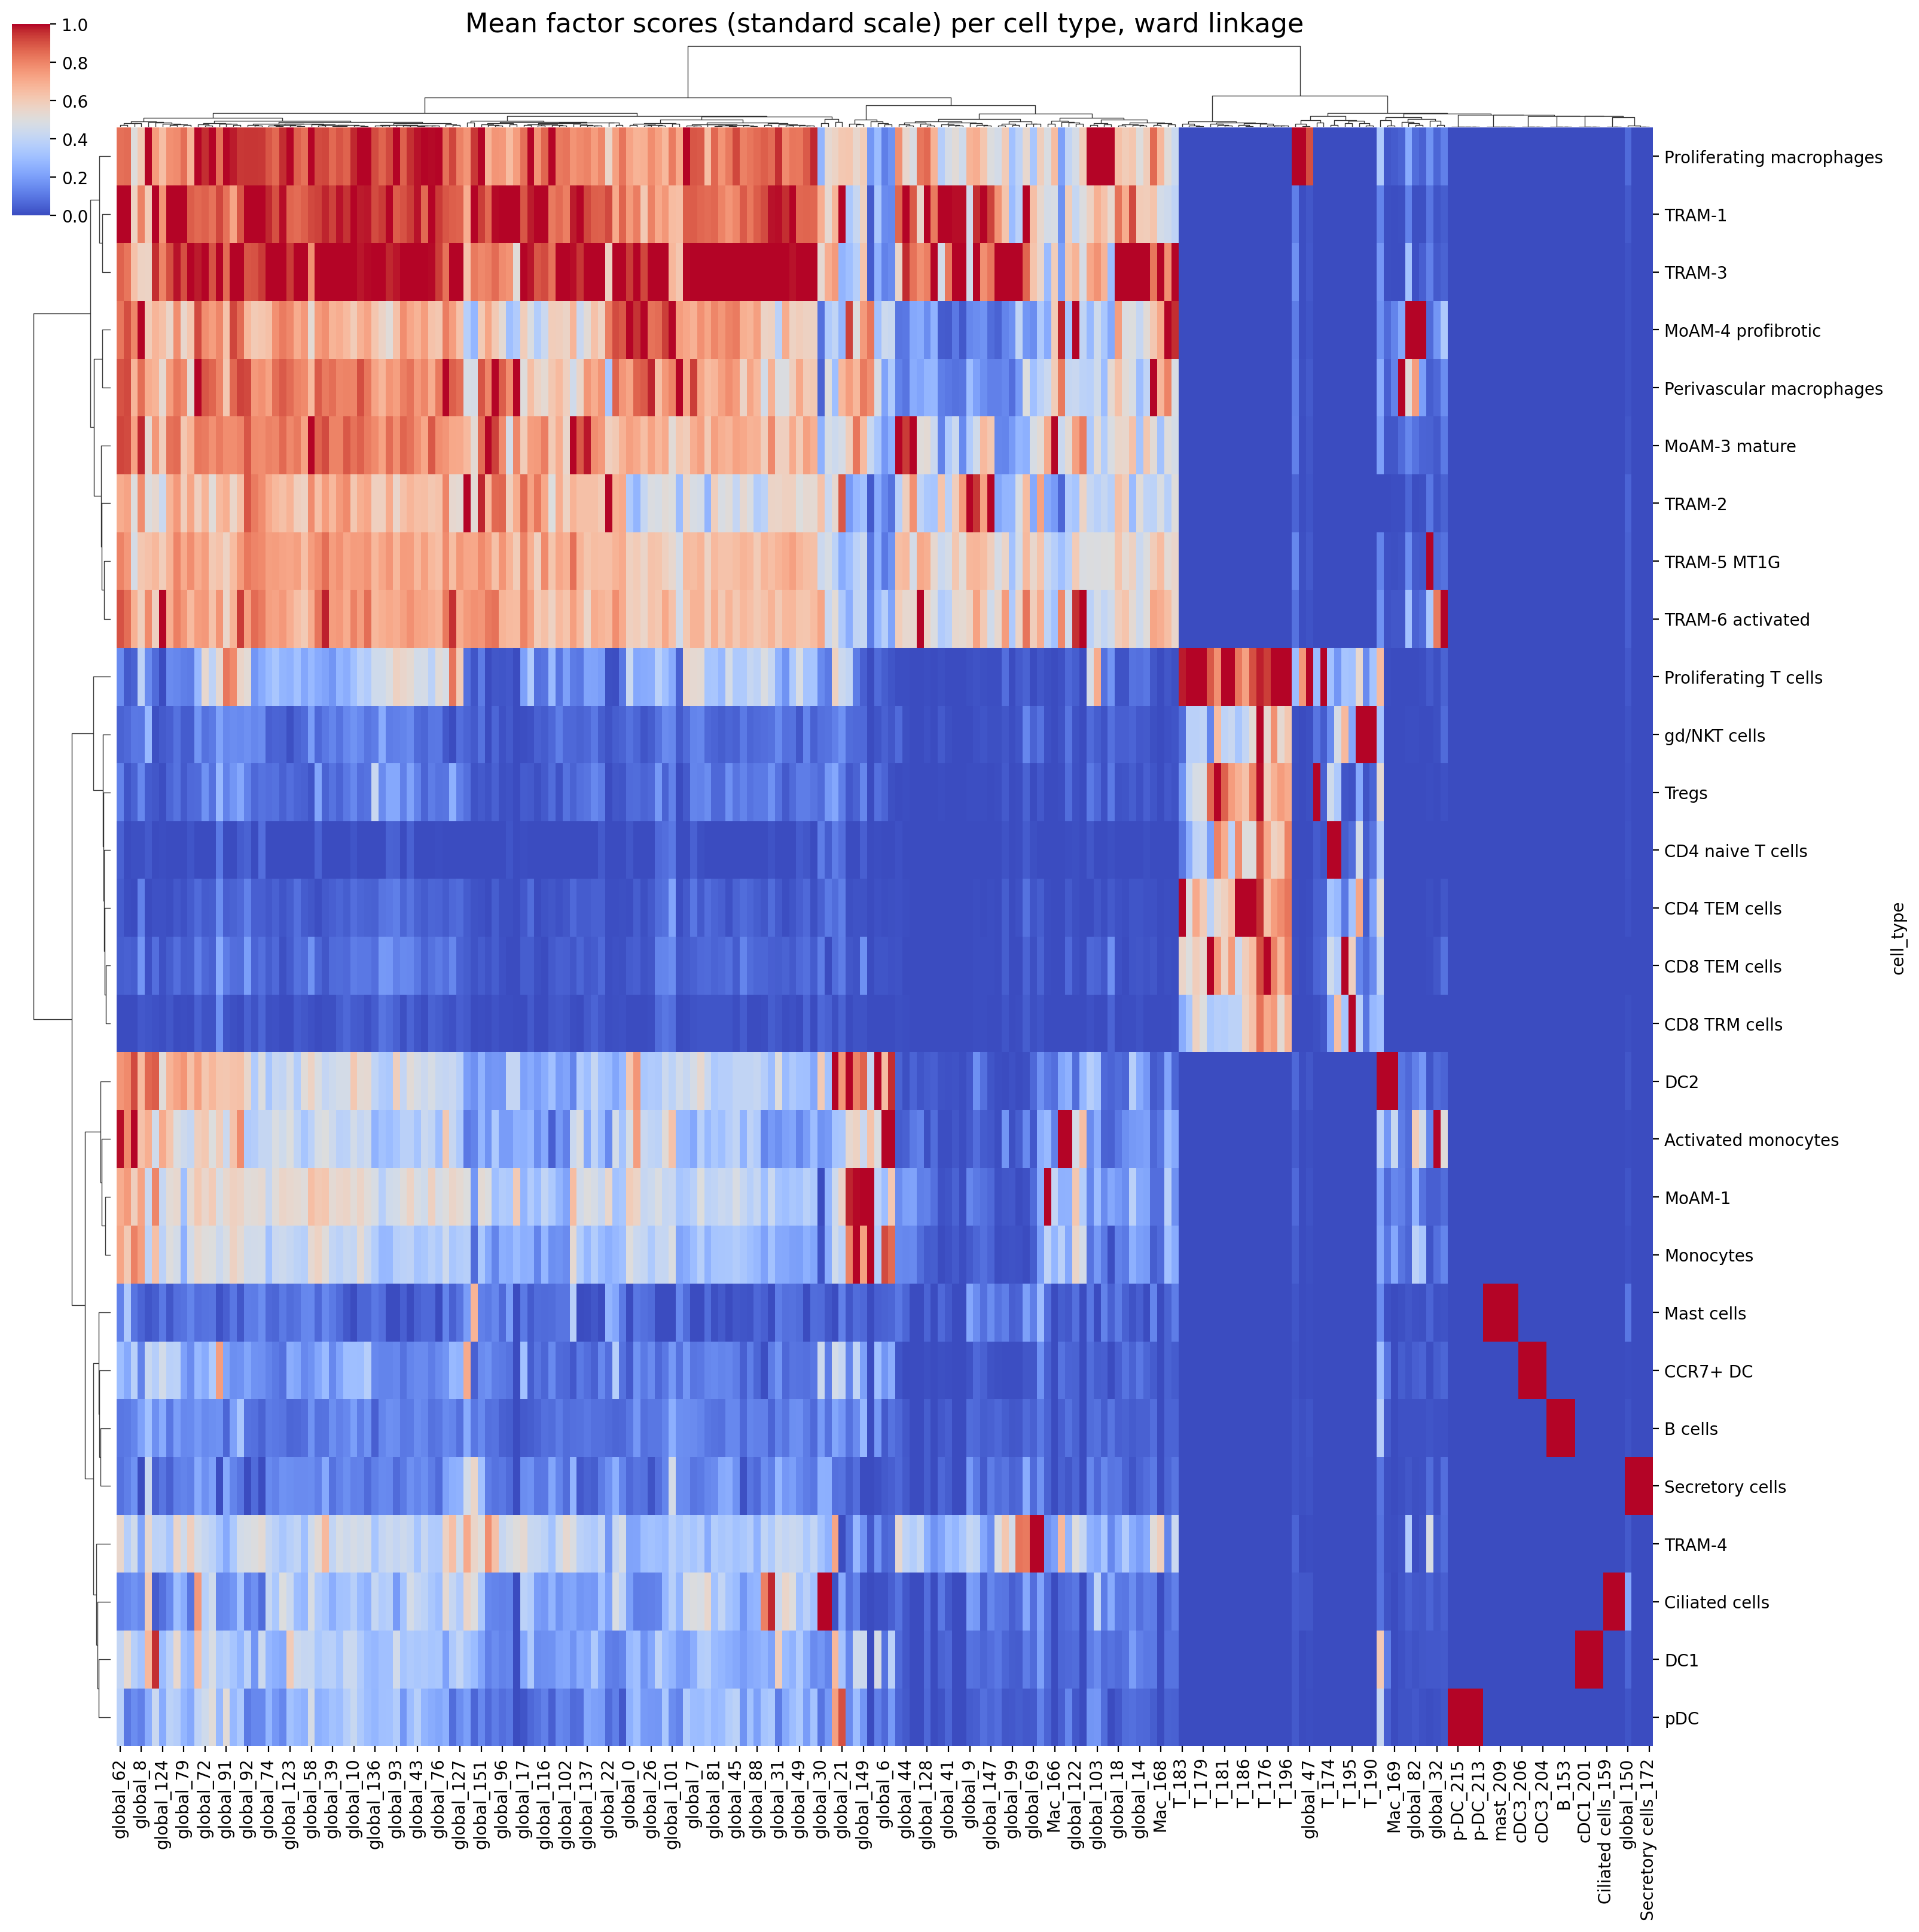

In [ ]:
cg = sns.clustermap(
    cell_scores3.groupby("cell_type").mean(),
#     annot=True,
    cmap='coolwarm',
    method='ward',
    # ax=ax,
#     cbar=None,
#     fmt=".3f",
    dendrogram_ratio=0.05,
    standard_scale=1,
#     cbar_pos=None,
    figsize=(16, 16),
#     xticklabels=[],
#     yticklabels=[]
#     annot_kws={"size": 8}
)
p = cg.ax_cbar.get_position()
p.x0 = 0
p.x1 = 0.02
p.y0 = 0.9
p.y1 = 1
cg.ax_cbar.set_position(p)
cg.ax_col_dendrogram.set_title("Mean factor scores (standard scale) per cell type, ward linkage", size=16)

Let's filter the above matrix and exclude factors whose maximal mean weight per cell type is below `0.0005`

Text(0.5, 1.0, 'Mean factor scores per cell type, ward linkage')

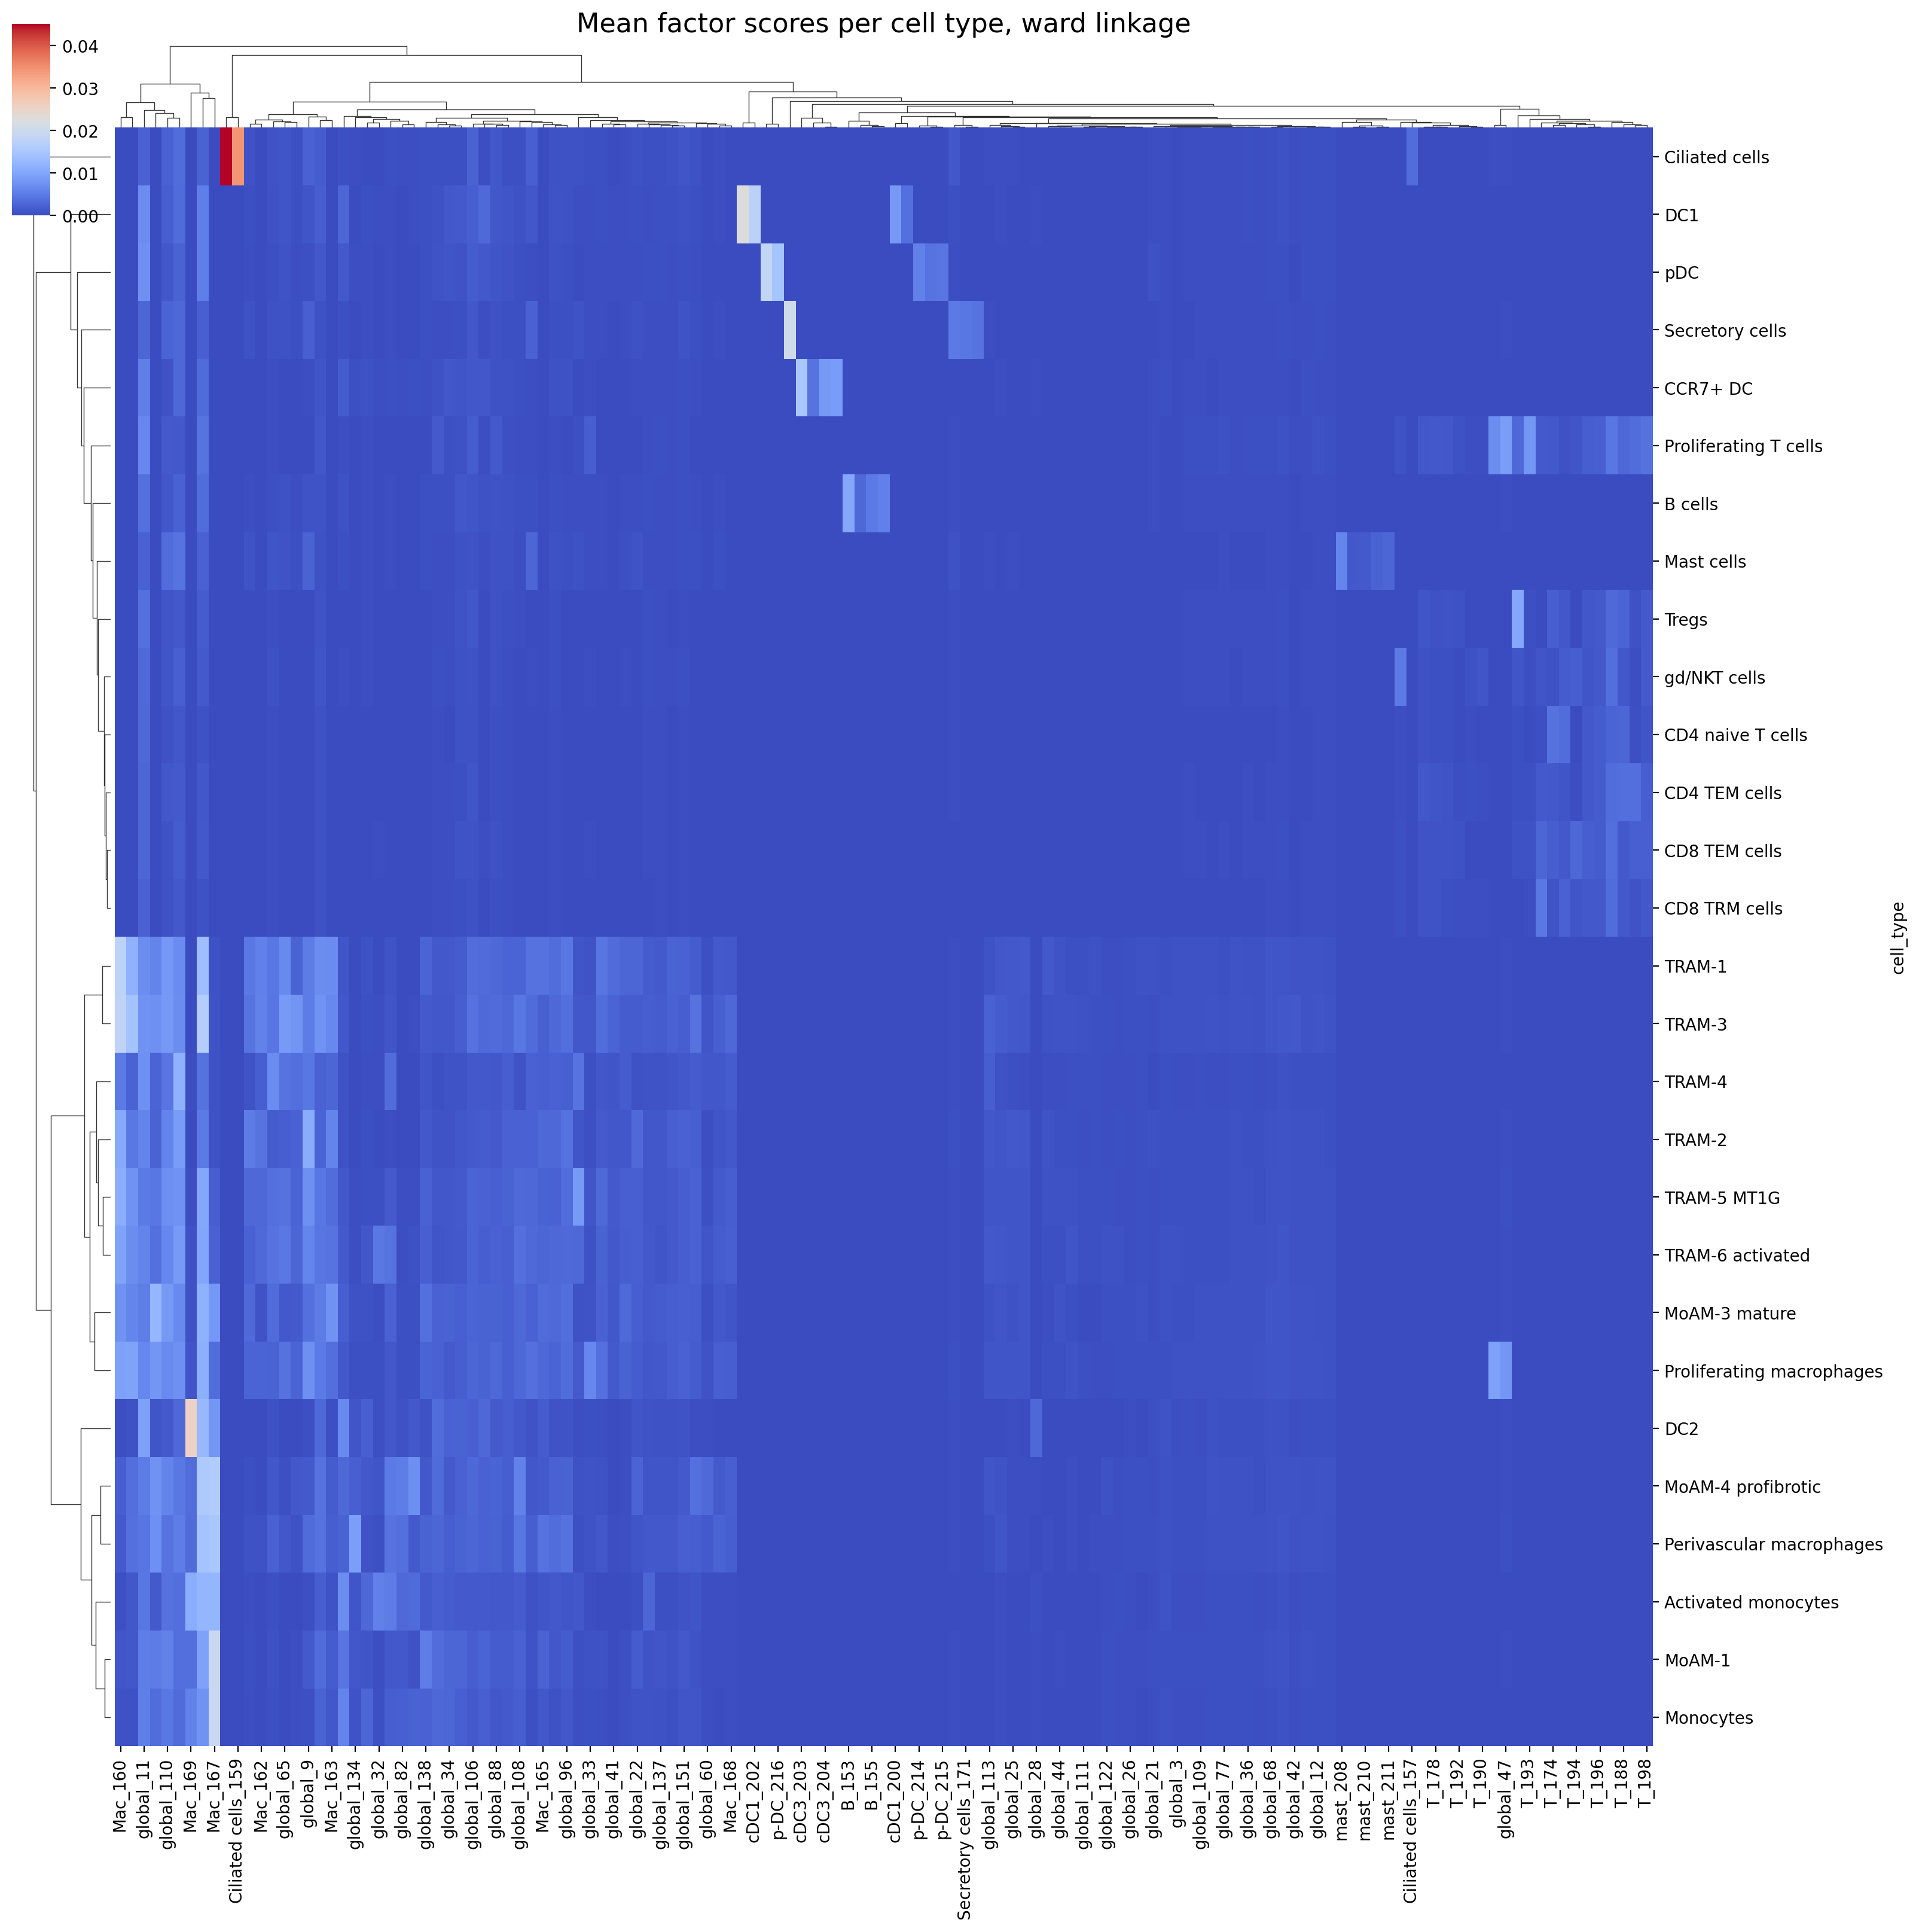

In [ ]:
cell_score_mtx = cell_scores3.groupby("cell_type").mean()
cg = sns.clustermap(
    cell_score_mtx.loc[:, cell_score_mtx.max() > 0.0005],
#     annot=True,
    cmap='coolwarm',
    method='ward',
    # ax=ax,
#     cbar=None,
#     fmt=".3f",
    dendrogram_ratio=0.05,
#     cbar_pos=None,
    figsize=(16, 16),
#     xticklabels=[],
#     yticklabels=[]
#     annot_kws={"size": 8}
)
p = cg.ax_cbar.get_position()
p.x0 = 0
p.x1 = 0.02
p.y0 = 0.9
p.y1 = 1
cg.ax_cbar.set_position(p)
cg.ax_col_dendrogram.set_title("Mean factor scores per cell type, ward linkage", size=16)

### 5. Look at mean factor score by patient/disease among all TRAMs

Let's take all TRAMs (TRAM-1, TRAM-2, TRAM-3, TRAM-4, TRAM-5 MT1G and TRAM-6 activated) and compute mean factors for all these cells grouped by sample.

Do we see different factors for control vs patients with SSc? Annotate samples by Status and Chemistry.

In [149]:
cell_scores4 = cell_scores.copy()
cell_scores4["Patient_status"] = adata.obs.Sample.astype(str) + "_" + adata.obs.Status.astype(str)

In [150]:
cell_scores4 = cell_scores4.loc[adata.obs.cell_type.str.startswith("TRAM"), :]

In [151]:
cell_score_mtx = cell_scores4.groupby("Patient_status").mean()

In [152]:
chemistry = adata.obs[["Sample", "Status", "Chemistry"]].drop_duplicates()
chemistry.Sample = chemistry.Sample.astype(str) + "_" + chemistry.Status.astype(str)
chemistry = chemistry.set_index("Sample").Chemistry

In [153]:
row_colors = pd.DataFrame(index=cell_score_mtx.index)
row_colors["Status"] = ["red" if "SSc" in x else "skyblue" for x in row_colors.index]
row_colors["Chemistry"] = chemistry[row_colors.index].values
row_colors.Chemistry = row_colors.Chemistry.astype("category")
row_colors.Chemistry = [mpl.cm.tab10(i) for i in row_colors.Chemistry.cat.codes]

In [ ]:
cg = sns.clustermap(
    cell_score_mtx.loc[:, cell_score_mtx.sum(axis=0) > 0],
#     annot=True,
    cmap='coolwarm',
    method='ward',
    row_colors=row_colors,
    standard_scale=1,
    # ax=ax,
#     cbar=None,
#     fmt=".3f",
    dendrogram_ratio=0.05,
#     cbar_pos=None,
    figsize=(16, 16),
#     xticklabels=[],
#     yticklabels=[]
#     annot_kws={"size": 8}
)
p = cg.ax_cbar.get_position()
p.x0 = 0
p.x1 = 0.02
p.y0 = 0.9
p.y1 = 1
cg.ax_cbar.set_position(p)
cg.ax_col_dendrogram.set_title("Mean factor scores (standard scale) per Patient, ward linkage", size=16)

Let's filter the above matrix and exclude factors whose maximal mean weight per cell type is below `0.001`

In [ ]:
cg = sns.clustermap(
    cell_score_mtx.loc[:, cell_score_mtx.max() > 0.001],
#     annot=True,
    cmap='coolwarm',
    method='ward',
    row_colors=row_colors,
    standard_scale=1,
    # ax=ax,
#     cbar=None,
#     fmt=".3f",
    dendrogram_ratio=0.05,
#     cbar_pos=None,
    figsize=(16, 16),
#     xticklabels=[],
#     yticklabels=[]
#     annot_kws={"size": 8}
)
p = cg.ax_cbar.get_position()
p.x0 = 0
p.x1 = 0.02
p.y0 = 0.9
p.y1 = 1
cg.ax_cbar.set_position(p)
cg.ax_col_dendrogram.set_title("Mean factor scores (standard scale) per Patient, ward linkage", size=16)

### Let's check only Macrophage factors for this analysis

In [ ]:
cg = sns.clustermap(
    cell_score_mtx.loc[:, factor_celltype_df.cell_type.eq('Mac')],
    cmap='coolwarm',
    method='ward',
    row_colors=row_colors,
    standard_scale=1,
    dendrogram_ratio=0.05,
    figsize=(16, 16),
)
p = cg.ax_cbar.get_position()
p.x0 = 0
p.x1 = 0.02
p.y0 = 0.9
p.y1 = 1
cg.ax_cbar.set_position(p)
cg.ax_col_dendrogram.set_title("Mean factor scores (standard scale) per Patient, ward linkage", size=16)

### Let's check only factors that don't correlate with nUMIs

In [ ]:
cg = sns.clustermap(
    cell_score_mtx.loc[:, factor_cell_corrs.nUMI.abs().lt(0.3)[:-1] & cell_score_mtx.max(axis=0).gt(0.001)],
    cmap='coolwarm',
    method='ward',
    row_colors=row_colors,
    standard_scale=1,
    dendrogram_ratio=0.05,
    figsize=(16, 16),
)
p = cg.ax_cbar.get_position()
p.x0 = 0
p.x1 = 0.02
p.y0 = 0.9
p.y1 = 1
cg.ax_cbar.set_position(p)
cg.ax_col_dendrogram.set_title("Mean factor scores (standard scale) per Patient, ward linkage", size=16)

### 6. Look at mean factor score by patient/disease among MoAM-3

Let's take MoAM-3 and compute mean factors for all these cells grouped by sample.

Do we see different factors for control vs patients with SSc? Annotate samples by Status and Chemistry.

In [159]:
cell_scores5 = cell_scores.copy()
cell_scores5["Patient_status"] = adata.obs.Sample.astype(str) + "_" + adata.obs.Status.astype(str)

In [160]:
cell_scores5 = cell_scores5.loc[adata.obs.cell_type.eq('MoAM-3 mature'), :]

In [161]:
cell_score_mtx = cell_scores5.groupby("Patient_status").mean()

In [162]:
chemistry = adata.obs[["Sample", "Status", "Chemistry"]].drop_duplicates()
chemistry.Sample = chemistry.Sample.astype(str) + "_" + chemistry.Status.astype(str)
chemistry = chemistry.set_index("Sample").Chemistry

In [163]:
row_colors = pd.DataFrame(index=cell_score_mtx.index)
row_colors["Status"] = ["red" if "SSc" in x else "skyblue" for x in row_colors.index]
row_colors["Chemistry"] = chemistry[row_colors.index].values
row_colors.Chemistry = row_colors.Chemistry.astype("category")
row_colors.Chemistry = [mpl.cm.tab10(i) for i in row_colors.Chemistry.cat.codes]

In [ ]:
cg = sns.clustermap(
    cell_score_mtx.loc[:, cell_score_mtx.sum(axis=0) > 0],
#     annot=True,
    cmap='coolwarm',
    method='ward',
    row_colors=row_colors,
    standard_scale=1,
    # ax=ax,
#     cbar=None,
#     fmt=".3f",
    dendrogram_ratio=0.05,
#     cbar_pos=None,
    figsize=(16, 16),
#     xticklabels=[],
#     yticklabels=[]
#     annot_kws={"size": 8}
)
p = cg.ax_cbar.get_position()
p.x0 = 0
p.x1 = 0.02
p.y0 = 0.9
p.y1 = 1
cg.ax_cbar.set_position(p)
cg.ax_col_dendrogram.set_title("Mean factor scores (standard scale) per Patient, ward linkage", size=16)

### Let's check only Macrophage factors for this analysis

In [ ]:
cg = sns.clustermap(
    cell_score_mtx.loc[:, factor_celltype_df.cell_type.eq('Mac')],
    cmap='coolwarm',
    method='ward',
    row_colors=row_colors,
    standard_scale=1,
    dendrogram_ratio=0.05,
    figsize=(16, 16),
)
p = cg.ax_cbar.get_position()
p.x0 = 0
p.x1 = 0.02
p.y0 = 0.9
p.y1 = 1
cg.ax_cbar.set_position(p)
cg.ax_col_dendrogram.set_title("Mean factor scores (standard scale) per Patient, ward linkage", size=16)

### Let's check only factors that don't correlate with nUMIs

In [ ]:
cg = sns.clustermap(
    cell_score_mtx.loc[:, factor_cell_corrs.nUMI.abs().lt(0.4)[:-1] & cell_score_mtx.max(axis=0).gt(0.001)],
    cmap='coolwarm',
    method='ward',
    row_colors=row_colors,
    standard_scale=1,
    dendrogram_ratio=0.05,
    figsize=(16, 16),
)
p = cg.ax_cbar.get_position()
p.x0 = 0
p.x1 = 0.02
p.y0 = 0.9
p.y1 = 1
cg.ax_cbar.set_position(p)
cg.ax_col_dendrogram.set_title("Mean factor scores (standard scale) per Patient, ward linkage", size=16)